# Using Group Id's the Right Way!


**TL:DR** :: Creating a model that reduces the inter-group dependency and validation error by using pair-wise comparisons. 

Hi All,
Although a little late to the party; I wanted to try out the competition but wasn't able to accept the competition rules in time. I decided to give it a try anyway. Read the discussions and found out about the data linkage hack and decided to find a way to use Group Id's in a way that the final model would only depend on the 128 time series values from the given training data.

### Model Layout:

So the basic idea for the project is to create a model that can reduces the modelling of group-specific patterns from the data and generalize well by focusing on surface-specific patternes in the data. The focus is on reducing inter-group validation error.
To do so, I have created a model that has the following structure:

**Input**:
Total inputs = 4 (2 for each samples)
*  Time series data for 2 samples, size = 128 (times steps) x 12 (features) each
*  Meta data for 2 samples, size = 8 x 12 (features) each

**Output**:
Total outputs = 4
*  2 Surface prediction, one for each sample.
*  Prediction wheter both samples have same Group Id.
*  Prediction wheter samples are take from same surface.

### Model Structure:
**first_inner model**:
This consists of raw time series input being fed into multiple CNN layers followed by a Bi-LSTM. Then it takes the global avg/max pooling for last CNN and Bi-LSTM and connects it to a FC layer.
Meta_Data is then concatenated to this FC layer which is again followed by a FC layer.

**second_inner model**:
This only consists of FC layers and the final output layer.

**main_model**:
This consists of 2 pairs of first_inner and second_inner models, followed by a few lambda layers that basically compare the output of the both the first_inner models. And predicts if the both the samples are from same group and if both the samples are of the same surface.

### Model for making predictions:
**Predictions**:
For final predictions, I didn't feel the need to create a separate model so I just feedfoward the data through first_inner and second_inner model sequentially.


## Feature Engineering:
Since the main intent was to just reduce the inter_group dependencies, I only scratched the surface of the data during FE. Computed basic statistical values from features for the Meta_data. 
Since the orientation data didnt

In [32]:
# Basics Imports for the kernel

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score
from scipy.stats import skew,kurtosis
from sklearn.preprocessing import StandardScaler
from numpy.fft import *
import keras
import math

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


Reading the Data in:

In [33]:
train_df = pd.read_csv('../input/X_train.csv')
test_df = pd.read_csv('../input/X_test.csv')

Checking out what the data represents:

In [34]:
train_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [35]:
test_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


Converting Quaternion to Euler and Tait Angles

In [36]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [37]:
def quaternions_conversion_1(actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [38]:
def quaternion_to_tait(q_val):
    #We assume q_val is in this format: [qw, q1, q2, q3]
    #And the quaternion is normalized
    roll = np.arctan2(2*(q_val[0]*q_val[1] + q_val[2]*q_val[3]),1 - 2*(q_val[1]*q_val[1] + q_val[2]*q_val[2]))
    pitch = np.arcsin(2*(q_val[0]*q_val[2] - q_val[3]*q_val[1]))
    yaw = np.arctan2(2*(q_val[0]*q_val[3] + q_val[1]*q_val[2]),1 - 2*(q_val[2]*q_val[2] + q_val[3]*q_val[3]))
    return roll, pitch, yaw

In [39]:
def quaternions_conversion_2(actual):
    """Quaternions to Tait Angles"""
    
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nr, np, ny = [], [], []
    for i in range(len(x)):
        rr, pp, yy = quaternion_to_tait([w[i], x[i], y[i], z[i]])
        nr.append(rr)
        np.append(pp)
        ny.append(yy)
    
    actual['roll'] = nr
    actual['pitch'] = np
    actual['yaw'] = ny
    
    return actual

Fucntion to de-noise the data using FFT

In [40]:
# from @theoviel at https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
def filter_signal(signal, threshold=1e3):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [41]:
def calculate_diffs(data,feature_columns):
        for ii,col in enumerate(feature_columns):
            if col in ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W','euler_x', 'euler_y', 'euler_z','roll','pitch','yaw']:
                np_arr = data[:,:,ii]
                roll_arr = np.copy(np_arr)
                roll_arr[:,1:] = roll_arr[:,:-1]
                np_arr = np_arr - roll_arr
                data[:,:,ii] = np_arr
                print(f'Calculated Diffs  : {col}')
            else:
                pass
                #print(f'Not changed : {col}')
        return data

In [42]:
def denoise(df,feature_columns):
    for ii,col in enumerate(feature_columns):
        if col in ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X','linear_acceleration_Y', 'linear_acceleration_Z']:
            denoised=df.groupby('series_id')[col].apply(lambda x:filter_signal(x))
            list_denoised = []
            for arr in denoised:
                for val in arr:
                    list_denoised.append(val)
            df[col] = list_denoised
            print(f'Denoised          : {col}')
        else:
            pass
            #print(f'Not changed : {col}')
    return df

Function to process the Training and Test data:

In [43]:
def process_data(train_df, Scalers=[]):
    
    feature_columns = train_df.columns[3:]
    train_df = denoise(train_df,feature_columns)
    train_df['totl_anglr_vel'] = np.power(np.power(train_df['angular_velocity_X'].values,2) + np.power(train_df['angular_velocity_Y'].values,2) \
                                      + np.power(train_df['angular_velocity_Z'].values,2),0.5)   

    train_df['totl_linear_accel'] = np.power(np.power(train_df['linear_acceleration_X'].values,2) + np.power(train_df['linear_acceleration_Y'].values,2) \
                                          + np.power(train_df['linear_acceleration_Z'].values,2),0.5) 
        
    train_df = quaternions_conversion_1(train_df)
    train_df = quaternions_conversion_2(train_df)
    
    feature_columns = train_df.columns[7:]
    features    = len(feature_columns)
    data = train_df[feature_columns].values
    data = data.reshape((data.shape[0]//128,128,features))
    
    data = calculate_diffs(data,feature_columns)
    
    
    meta_data = pd.DataFrame()
    for ii,col in enumerate(feature_columns):
        meta_data[col+'_mean'] = data[:,:,ii].mean(axis=1)
        meta_data[col+'_std']  = data[:,:,ii].std(axis=1)
        
        meta_data[col+'_min']  = data[:,:,ii].min(axis=1)
        meta_data[col+'_max']  = data[:,:,ii].max(axis=1)

        meta_data[col+'_diff_mean']  = np.diff(data[:,:,ii],axis=1).mean(axis=1)
        meta_data[col+'_diff_std']   = np.diff(data[:,:,ii],axis=1).std(axis=1)
        
        meta_data[col+'_skew']     = skew(data[:,:,ii],axis=1)
        meta_data[col+'_kurtosis'] = kurtosis(data[:,:,ii],axis=1)
        
    data = data.reshape((data.shape[0]*128,features))
    if Scalers==[]:
        SS = StandardScaler()
        SS.fit(data)
        Scalers.append(SS)
        SS_Meta = StandardScaler() 
        SS_Meta.fit(meta_data)
        Scalers.append(SS_Meta)
        
    data      = Scalers[0].transform(data)
    meta_data = Scalers[1].transform(meta_data)
         
    data = data.reshape((data.shape[0]//128,128,features))
    
    return data,meta_data,Scalers

In [44]:
data_train,meta_data_train,Scalers=process_data(train_df)

Denoised          : angular_velocity_X
Denoised          : angular_velocity_Y
Denoised          : angular_velocity_Z
Denoised          : linear_acceleration_X
Denoised          : linear_acceleration_Y
Denoised          : linear_acceleration_Z
Calculated Diffs  : euler_x
Calculated Diffs  : euler_y
Calculated Diffs  : euler_z
Calculated Diffs  : roll
Calculated Diffs  : pitch
Calculated Diffs  : yaw


In [45]:
data_test,meta_data_test,_=process_data(test_df,Scalers)

Denoised          : angular_velocity_X
Denoised          : angular_velocity_Y
Denoised          : angular_velocity_Z
Denoised          : linear_acceleration_X
Denoised          : linear_acceleration_Y
Denoised          : linear_acceleration_Z
Calculated Diffs  : euler_x
Calculated Diffs  : euler_y
Calculated Diffs  : euler_z
Calculated Diffs  : roll
Calculated Diffs  : pitch
Calculated Diffs  : yaw


In [46]:
train_y = pd.read_csv('../input/y_train.csv')

In [47]:
num_classes = len(train_y.surface.unique())
segments    = train_y.surface.size
features    = data_train.shape[2]

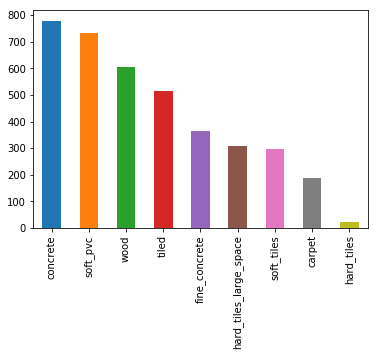

In [48]:
target = train_y.surface
_=train_y.surface.value_counts().plot(kind='bar')

From the histogram we can see that the classes are not blanced, hence we need to incorporate this imbalance in out model.

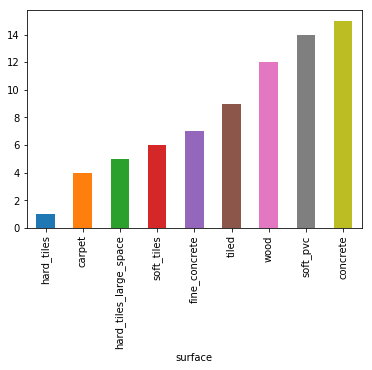

In [49]:
_=train_y.groupby('surface').group_id.unique().map(lambda x:len(x)).sort_values().plot(kind='bar')

Processing the surface labels to be understood by the model. 

Then creating training and validation sets using GroupShuffleSplit. Also ensuring that all training sets contain the hard-tiles group since there is only one group for this surface as shown from above histogram.

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target = le.fit_transform(train_y['surface'])

GS = GroupShuffleSplit(n_splits=13,random_state=513131,test_size=0.1)
folds = [(t,v) for (t,v) in GS.split(np.zeros((segments,)),groups=train_y.group_id)]

groups_hard_tiles = train_y.group_id[train_y.surface=='hard_tiles'].index.tolist()

folds_set = []
for t,v in folds:
    folds_set.append((np.array(list(set(t).union(groups_hard_tiles))),np.array(list(set(v).difference(groups_hard_tiles)))))
    
for ii,(t,v) in enumerate(folds_set):
    if 'hard_tiles' in train_y.surface.iloc[v].unique():
        print("Hard_Tiles present in fold no: {ii+1}")
else:
    print('Hard_tiles group is excluded from the validation sets')

Hard_tiles group is excluded from the validation sets


In [51]:
gc.collect()

61142

# Model Creation Starts Here

First_inner and second_inner model generator functions:

In [52]:
def first_inner_generator(out_units,l2,Spatial_dropout,dense_drop,noise):
    
    
    input_main = keras.layers.Input(shape=(128,features))

    cnn        = keras.layers.GaussianNoise(noise)(input_main)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*0,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    cnn        = keras.layers.MaxPool1D()(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*1,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    cnn        = keras.layers.MaxPool1D()(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*2,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*3,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    
    cnn        = keras.layers.Conv1D(out_units+(out_units//4)*4,3,kernel_regularizer=keras.regularizers.l2(l2))(cnn)
    cnn        = keras.layers.Activation('relu')(cnn)
    cnn        = keras.layers.SpatialDropout1D(Spatial_dropout)(cnn)
    
    LSTM       = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(out_units,return_sequences=True,kernel_regularizer=keras.regularizers.l2(l2)))(cnn)
    
    max_cnn    = keras.layers.GlobalMaxPool1D()(cnn)
    avg_cnn    = keras.layers.GlobalAvgPool1D()(cnn)
    
    max_LSTM   = keras.layers.GlobalMaxPool1D()(LSTM)
    avg_LSTM   = keras.layers.GlobalAvgPool1D()(LSTM)
    
    LSTM_last  = keras.layers.Lambda(lambda x:x[:,-1,:])(LSTM)
    
    dense     = keras.layers.Concatenate()([max_LSTM,avg_LSTM,max_cnn,avg_cnn,LSTM_last])
    
    dense      = keras.layers.Dense(out_units,activation=keras.activations.relu)(dense)
    dense      = keras.layers.GaussianDropout(dense_drop)(dense) 
    
    input_meta = keras.layers.Input(shape=(meta_data_train.shape[1],))
    
    meta      = keras.layers.GaussianNoise(noise*2)(input_meta)
    dense     = keras.layers.Concatenate()([dense,meta])
        
    dense      = keras.layers.Dense(out_units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(dense)
    dense      = keras.layers.GaussianDropout(dense_drop)(dense)
    
    dense      = keras.layers.Dense(out_units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(dense)
    dense      = keras.layers.GaussianDropout(dense_drop)(dense)
         

    return keras.Model([input_main,input_meta],dense)

In [53]:
def second_inner_generator(in_units,l2,Spatial_dropout,dense_drop):
    
    input_main = keras.layers.Input(shape=(in_units,))

    dense        = keras.layers.Dense(in_units,activation = keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(input_main)
    dense        = keras.layers.GaussianDropout(dense_drop)(dense)
  
    out          = keras.layers.Dense(num_classes,kernel_regularizer=keras.regularizers.l2(l2),activation = keras.activations.softmax)(dense)
    
    return keras.Model(input_main,out)

Main Model Generator Function:

In [54]:
def model_generator(units,l2,Spatial_dropout,dense_drop,noise):
    
    model_inner   = first_inner_generator(units,l2,Spatial_dropout,dense_drop,noise)
    model_outer   = second_inner_generator(units,l2,Spatial_dropout,dense_drop)
    
    
    input_main_a = keras.layers.Input(shape=(128,features))
    input_main_b = keras.layers.Input(shape=(128,features))
    
    input_meta_a = keras.layers.Input(shape=(meta_data_train.shape[1],))
    input_meta_b = keras.layers.Input(shape=(meta_data_train.shape[1],))

    model_inner_a  = model_inner([input_main_a,input_meta_a])
    model_inner_b  = model_inner([input_main_b,input_meta_b])
    
    model_outer_a  = model_outer(model_inner_a)
    model_outer_b  = model_outer(model_inner_b)
    
    dense_a       = keras.layers.Lambda(lambda x:x,name='a')(model_outer_a)
    dense_b       = keras.layers.Lambda(lambda x:x,name='b')(model_outer_b)

    pair_wise_out = keras.layers.Subtract()([model_inner_a,model_inner_b])
    pair_wise_out = keras.layers.Lambda(lambda x:keras.backend.abs(x))(pair_wise_out)
    
    pair_wise_out_group = keras.layers.Dense(units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(pair_wise_out)
    pair_wise_out_group = keras.layers.GaussianDropout(dense_drop)(pair_wise_out_group)
    
    pair_wise_out_group = keras.layers.Dense(1,activation=keras.activations.sigmoid,kernel_regularizer=keras.regularizers.l2(l2),name='pair_wise_group')(pair_wise_out_group) 
    
    pair_wise_out_surf = keras.layers.Dense(units,activation=keras.activations.relu,kernel_regularizer=keras.regularizers.l2(l2))(pair_wise_out)
    pair_wise_out_surf = keras.layers.GaussianDropout(dense_drop)(pair_wise_out_surf)
            
    pair_wise_out_surf  = keras.layers.Dense(1,activation=keras.activations.sigmoid,kernel_regularizer=keras.regularizers.l2(l2),name='pair_wise_surf')(pair_wise_out_surf)
    
    model =  keras.Model([input_main_a,input_main_b,input_meta_a,input_meta_b],[dense_a,dense_b,pair_wise_out_group,pair_wise_out_surf]) 

    return model,model_inner,model_outer

Need to create a genarator for Main_model input, utilizing Keras Sequence Class for the purpose.

Each Epoch contains the 2 x No. of samples in training data.

In [57]:
class generator(keras.utils.Sequence):
    def __init__(self, data, meta, target, group, batch_size, slicing, mode='Training'):
            if slicing is None:
                self.data, self.meta, self.target, self.group, self.batch_size = data, meta, target, group, batch_size
            else:
                self.data, self.meta, self.target, self.group, self.batch_size = data[slicing], meta[slicing], target[slicing], group[slicing], batch_size
            
            self.num_samples = self.data.shape[0]
                
            self.epoch_a_data   = np.zeros(shape=(self.num_samples,self.data.shape[1],self.data.shape[2]))
            self.epoch_b_data   = np.zeros(shape=(self.num_samples,self.data.shape[1],self.data.shape[2]))
            
            self.epoch_a_meta   = np.zeros(shape=(self.num_samples,self.meta.shape[1]))
            self.epoch_b_meta   = np.zeros(shape=(self.num_samples,self.meta.shape[1]))
            
            self.epoch_a_target = np.zeros(shape=(self.num_samples,1))
            self.epoch_b_target = np.zeros(shape=(self.num_samples,1))
            
            self.pair_wise_group   = np.zeros(shape=(self.num_samples,1))
            self.pair_wise_surface = np.zeros(shape=(self.num_samples,1))
            
            self.counter = 0
                        
            print(f"Processing {int(self.data.shape[0])} Samples for {mode}")
            
            self.on_epoch_end()            
            

    def __len__(self):
        self.steps = (self.num_samples//self.batch_size) + 1
        return self.steps

    def __getitem__(self, idx):
        if idx < self.steps-1:
            batch_a_data       = self.epoch_a_data[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_b_data       = self.epoch_b_data[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_a_meta       = self.epoch_a_meta[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_b_meta       = self.epoch_b_meta[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_a_target     = self.epoch_a_target[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_b_target     = self.epoch_b_target[idx * self.batch_size:(idx + 1) * self.batch_size]

            batch_pair_groups  = self.pair_wise_group[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_pair_surface = self.pair_wise_surface[idx * self.batch_size:(idx + 1) * self.batch_size]


            return [batch_a_data,batch_b_data,batch_a_meta,batch_b_meta],[batch_a_target,batch_b_target,batch_pair_groups,batch_pair_surface]
        else:
            batch_a_data       = self.epoch_a_data[-self.batch_size:]
            batch_b_data       = self.epoch_b_data[-self.batch_size:]

            batch_a_meta       = self.epoch_a_meta[-self.batch_size:]
            batch_b_meta       = self.epoch_b_meta[-self.batch_size:]

            batch_a_target     = self.epoch_a_target[-self.batch_size:]
            batch_b_target     = self.epoch_b_target[-self.batch_size:]

            batch_pair_groups  = self.pair_wise_group[-self.batch_size:]
            batch_pair_surface = self.pair_wise_surface[-self.batch_size:]


            return [batch_a_data,batch_b_data,batch_a_meta,batch_b_meta],[batch_a_target,batch_b_target,batch_pair_groups,batch_pair_surface]

    def on_epoch_end(self):
        np.random.seed(513131 + self.counter)
        self.pairs_a = np.random.choice(self.num_samples,size=(self.num_samples,),replace=False)
        self.pairs_b = np.random.choice(self.num_samples,size=(self.num_samples,),replace=True)
        self.counter+=1
        for ii in range(self.num_samples):
            self.epoch_a_data[ii]   = self.data[self.pairs_a[ii]]
            self.epoch_b_data[ii]   = self.data[self.pairs_b[ii]]

            self.epoch_a_meta[ii]   = self.meta[self.pairs_a[ii]]
            self.epoch_b_meta[ii]   = self.meta[self.pairs_b[ii]]

            self.epoch_a_target[ii] = self.target[self.pairs_a[ii]]
            self.epoch_b_target[ii] = self.target[self.pairs_b[ii]]

            self.pair_wise_group[ii]   = self.group[self.pairs_a[ii]]!=self.group[self.pairs_b[ii]]
            self.pair_wise_surface[ii] = self.target[self.pairs_a[ii]]!=self.target[self.pairs_b[ii]]
            

In [ ]:
validation_scores= []
training_scores = []
test_scores = np.zeros(shape=(data_test.shape[0],len(folds_set),num_classes))

histories = []
for ii,(t,v) in enumerate(folds_set):
    keras.backend.clear_session()
    model,model_inner,model_outer = model_generator(units=32,l2=0.002,Spatial_dropout=0.1,dense_drop=0.1,noise=0.1)
    gc.collect()
    if ii==0:
        for m in [model_inner,model_outer,model,]:
            m.summary()
            
    
    print(f"\nModel {ii+1}/{len(folds_set)}:")
    model.compile(optimizer=keras.optimizers.Adadelta(),loss={'a':keras.losses.sparse_categorical_crossentropy,'b':keras.losses.sparse_categorical_crossentropy,
                                                         'pair_wise_group':keras.losses.binary_crossentropy,'pair_wise_surf':keras.losses.binary_crossentropy},
              metrics={'a':keras.metrics.sparse_categorical_accuracy,'b':keras.metrics.sparse_categorical_accuracy,
                      'pair_wise_group':keras.metrics.binary_accuracy,'pair_wise_surf':keras.metrics.binary_accuracy},
             loss_weights=[1,1,2,2])
    
    counts = pd.Series(target[t]).value_counts()
    weights = {ii:counts.max()/val for ii,val in zip(counts.index,counts)}
    weights = {ii:weights.get(ii,1) for ii in range(num_classes)}
    
    print('Class Weights : ',[(ii,np.round(weights[ii],decimals=2)) for ii in sorted(weights.keys())],'\n\n')
    
    hist = model.fit_generator(generator=generator(data=data_train,meta=meta_data_train,target=target,group=train_y.group_id.values,batch_size=32,slicing=t),
                          validation_data=generator(data=data_train,meta=meta_data_train,target=target,group=train_y.group_id.values,batch_size=32,slicing=v,mode='Validation'),
                          epochs=300,verbose=2,class_weight={'a':{ii:weights[ii] for ii in sorted(weights)},'b':{ii:weights[ii] for ii in sorted(weights)},
                         'pair_wise_group':{1:1,0:train_y.group_id[t].unique().size},'pair_wise_surf':{1:1,0:train_y.surface[t].unique().size}})

    histories.append(hist)
    
    preds_train    = model_inner.predict(x=[data_train[v],meta_data_train[v]])
    preds_train    = model_outer.predict(x=preds_train)
    validation_scores.append(accuracy_score(target[v],preds_train.argmax(axis=1)))
    print('Validation Score :', np.round(validation_scores[-1],decimals=3))
    
    preds_train    = model_inner.predict(x=[data_train[t],meta_data_train[t]])
    preds_train    = model_outer.predict(x=preds_train)
    training_scores.append(accuracy_score(target[t],preds_train.argmax(axis=1)))
    print('Training Score :', np.round(training_scores[-1],decimals=3))
    
    
    preds_test           = model_inner.predict(x=[data_test,meta_data_test])
    preds_test           = model_outer.predict(x=preds_test)
    test_scores[:,ii,:]  = preds_test

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 14)      0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 128, 14)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 126, 32)      1376        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 126, 32)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
spatial_dr

Class Weights :  [(0, 3.79), (1, 1.02), (2, 1.86), (3, 32.14), (4, 2.19), (5, 1.0), (6, 2.81), (7, 1.31), (8, 1.24)] 


Processing 3504 Samples for Training
Processing 306 Samples for Validation
Epoch 1/300
 - 7s - loss: 13.4395 - a_loss: 3.5208 - b_loss: 3.4312 - pair_wise_group_loss: 1.6597 - pair_wise_surf_loss: 1.5118 - a_sparse_categorical_accuracy: 0.2116 - b_sparse_categorical_accuracy: 0.2199 - pair_wise_group_binary_accuracy: 0.3580 - pair_wise_surf_binary_accuracy: 0.3523 - val_loss: 7.5516 - val_a_loss: 1.9391 - val_b_loss: 1.9663 - val_pair_wise_group_loss: 0.6387 - val_pair_wise_surf_loss: 0.7741 - val_a_sparse_categorical_accuracy: 0.2437 - val_b_sparse_categorical_accuracy: 0.2344 - val_pair_wise_group_binary_accuracy: 0.6406 - val_pair_wise_surf_binary_accuracy: 0.3937
Epoch 2/300
 - 4s - loss: 11.9036 - a_loss: 3.1508 - b_loss: 3.0816 - pair_wise_group_loss: 1.4131 - pair_wise_surf_loss: 1.4873 - a_sparse_categorical_accuracy: 0.2798 - b_sparse_categorical_accuracy: 0.

Epoch 15/300
 - 4s - loss: 9.2337 - a_loss: 2.2932 - b_loss: 2.3433 - pair_wise_group_loss: 1.2765 - pair_wise_surf_loss: 1.3100 - a_sparse_categorical_accuracy: 0.4364 - b_sparse_categorical_accuracy: 0.4372 - pair_wise_group_binary_accuracy: 0.7304 - pair_wise_surf_binary_accuracy: 0.4943 - val_loss: 5.9210 - val_a_loss: 1.6144 - val_b_loss: 1.6485 - val_pair_wise_group_loss: 0.5301 - val_pair_wise_surf_loss: 0.7149 - val_a_sparse_categorical_accuracy: 0.3219 - val_b_sparse_categorical_accuracy: 0.3000 - val_pair_wise_group_binary_accuracy: 0.7469 - val_pair_wise_surf_binary_accuracy: 0.5406
Epoch 16/300
 - 4s - loss: 9.1413 - a_loss: 2.2785 - b_loss: 2.3082 - pair_wise_group_loss: 1.1894 - pair_wise_surf_loss: 1.3340 - a_sparse_categorical_accuracy: 0.4440 - b_sparse_categorical_accuracy: 0.4491 - pair_wise_group_binary_accuracy: 0.7517 - pair_wise_surf_binary_accuracy: 0.4648 - val_loss: 5.5738 - val_a_loss: 1.5404 - val_b_loss: 1.4695 - val_pair_wise_group_loss: 0.5070 - val_pair_

Epoch 29/300
 - 4s - loss: 7.9178 - a_loss: 1.8537 - b_loss: 1.8517 - pair_wise_group_loss: 1.0268 - pair_wise_surf_loss: 1.2438 - a_sparse_categorical_accuracy: 0.5614 - b_sparse_categorical_accuracy: 0.5602 - pair_wise_group_binary_accuracy: 0.7668 - pair_wise_surf_binary_accuracy: 0.5705 - val_loss: 5.5027 - val_a_loss: 1.5399 - val_b_loss: 1.5982 - val_pair_wise_group_loss: 0.4070 - val_pair_wise_surf_loss: 0.6292 - val_a_sparse_categorical_accuracy: 0.2031 - val_b_sparse_categorical_accuracy: 0.1594 - val_pair_wise_group_binary_accuracy: 0.8438 - val_pair_wise_surf_binary_accuracy: 0.6875
Epoch 30/300
 - 4s - loss: 8.2665 - a_loss: 1.8455 - b_loss: 1.7720 - pair_wise_group_loss: 1.4294 - pair_wise_surf_loss: 1.2609 - a_sparse_categorical_accuracy: 0.5622 - b_sparse_categorical_accuracy: 0.5619 - pair_wise_group_binary_accuracy: 0.7148 - pair_wise_surf_binary_accuracy: 0.5452 - val_loss: 5.3404 - val_a_loss: 1.5497 - val_b_loss: 1.4980 - val_pair_wise_group_loss: 0.4976 - val_pair_

Epoch 43/300
 - 4s - loss: 7.6757 - a_loss: 1.6435 - b_loss: 1.5588 - pair_wise_group_loss: 1.2716 - pair_wise_surf_loss: 1.2368 - a_sparse_categorical_accuracy: 0.6125 - b_sparse_categorical_accuracy: 0.6222 - pair_wise_group_binary_accuracy: 0.7293 - pair_wise_surf_binary_accuracy: 0.5744 - val_loss: 6.6371 - val_a_loss: 1.9536 - val_b_loss: 2.0924 - val_pair_wise_group_loss: 0.4822 - val_pair_wise_surf_loss: 0.6888 - val_a_sparse_categorical_accuracy: 0.1656 - val_b_sparse_categorical_accuracy: 0.1531 - val_pair_wise_group_binary_accuracy: 0.7937 - val_pair_wise_surf_binary_accuracy: 0.6406
Epoch 44/300
 - 4s - loss: 7.1034 - a_loss: 1.5261 - b_loss: 1.4794 - pair_wise_group_loss: 0.9872 - pair_wise_surf_loss: 1.1888 - a_sparse_categorical_accuracy: 0.6295 - b_sparse_categorical_accuracy: 0.6256 - pair_wise_group_binary_accuracy: 0.7693 - pair_wise_surf_binary_accuracy: 0.5957 - val_loss: 5.1508 - val_a_loss: 1.4827 - val_b_loss: 1.4346 - val_pair_wise_group_loss: 0.3937 - val_pair_

Epoch 57/300
 - 4s - loss: 6.9387 - a_loss: 1.3528 - b_loss: 1.4141 - pair_wise_group_loss: 1.1608 - pair_wise_surf_loss: 1.1233 - a_sparse_categorical_accuracy: 0.6707 - b_sparse_categorical_accuracy: 0.6739 - pair_wise_group_binary_accuracy: 0.7386 - pair_wise_surf_binary_accuracy: 0.6446 - val_loss: 4.6663 - val_a_loss: 1.2063 - val_b_loss: 1.1255 - val_pair_wise_group_loss: 0.4532 - val_pair_wise_surf_loss: 0.5576 - val_a_sparse_categorical_accuracy: 0.5000 - val_b_sparse_categorical_accuracy: 0.5500 - val_pair_wise_group_binary_accuracy: 0.8313 - val_pair_wise_surf_binary_accuracy: 0.6844
Epoch 58/300
 - 4s - loss: 6.7044 - a_loss: 1.4070 - b_loss: 1.3430 - pair_wise_group_loss: 1.0046 - pair_wise_surf_loss: 1.0912 - a_sparse_categorical_accuracy: 0.6844 - b_sparse_categorical_accuracy: 0.6722 - pair_wise_group_binary_accuracy: 0.7466 - pair_wise_surf_binary_accuracy: 0.6616 - val_loss: 5.3140 - val_a_loss: 1.4254 - val_b_loss: 1.4650 - val_pair_wise_group_loss: 0.4384 - val_pair_

Epoch 71/300
 - 4s - loss: 6.4796 - a_loss: 1.2484 - b_loss: 1.2540 - pair_wise_group_loss: 1.0802 - pair_wise_surf_loss: 1.0537 - a_sparse_categorical_accuracy: 0.6991 - b_sparse_categorical_accuracy: 0.7148 - pair_wise_group_binary_accuracy: 0.7824 - pair_wise_surf_binary_accuracy: 0.6662 - val_loss: 5.3448 - val_a_loss: 1.5108 - val_b_loss: 1.4235 - val_pair_wise_group_loss: 0.4674 - val_pair_wise_surf_loss: 0.5767 - val_a_sparse_categorical_accuracy: 0.3781 - val_b_sparse_categorical_accuracy: 0.4062 - val_pair_wise_group_binary_accuracy: 0.8313 - val_pair_wise_surf_binary_accuracy: 0.7063
Epoch 72/300
 - 4s - loss: 6.4085 - a_loss: 1.2108 - b_loss: 1.2749 - pair_wise_group_loss: 1.0140 - pair_wise_surf_loss: 1.0588 - a_sparse_categorical_accuracy: 0.7040 - b_sparse_categorical_accuracy: 0.6895 - pair_wise_group_binary_accuracy: 0.7509 - pair_wise_surf_binary_accuracy: 0.6688 - val_loss: 5.2070 - val_a_loss: 1.4566 - val_b_loss: 1.4058 - val_pair_wise_group_loss: 0.4175 - val_pair_

Epoch 85/300
 - 4s - loss: 5.9754 - a_loss: 1.1451 - b_loss: 1.1242 - pair_wise_group_loss: 0.8482 - pair_wise_surf_loss: 1.0203 - a_sparse_categorical_accuracy: 0.7114 - b_sparse_categorical_accuracy: 0.7151 - pair_wise_group_binary_accuracy: 0.8026 - pair_wise_surf_binary_accuracy: 0.6929 - val_loss: 5.4504 - val_a_loss: 1.4784 - val_b_loss: 1.4670 - val_pair_wise_group_loss: 0.4331 - val_pair_wise_surf_loss: 0.6271 - val_a_sparse_categorical_accuracy: 0.4531 - val_b_sparse_categorical_accuracy: 0.4344 - val_pair_wise_group_binary_accuracy: 0.8500 - val_pair_wise_surf_binary_accuracy: 0.6656
Epoch 86/300
 - 4s - loss: 6.1918 - a_loss: 1.1465 - b_loss: 1.1351 - pair_wise_group_loss: 1.0733 - pair_wise_surf_loss: 1.0098 - a_sparse_categorical_accuracy: 0.7233 - b_sparse_categorical_accuracy: 0.7122 - pair_wise_group_binary_accuracy: 0.7747 - pair_wise_surf_binary_accuracy: 0.7020 - val_loss: 5.2373 - val_a_loss: 1.5054 - val_b_loss: 1.4925 - val_pair_wise_group_loss: 0.4139 - val_pair_

Epoch 99/300
 - 4s - loss: 5.9228 - a_loss: 1.0343 - b_loss: 1.1063 - pair_wise_group_loss: 0.9870 - pair_wise_surf_loss: 0.9753 - a_sparse_categorical_accuracy: 0.7386 - b_sparse_categorical_accuracy: 0.7344 - pair_wise_group_binary_accuracy: 0.8014 - pair_wise_surf_binary_accuracy: 0.7173 - val_loss: 5.3363 - val_a_loss: 1.3771 - val_b_loss: 1.4291 - val_pair_wise_group_loss: 0.4610 - val_pair_wise_surf_loss: 0.6117 - val_a_sparse_categorical_accuracy: 0.5719 - val_b_sparse_categorical_accuracy: 0.5406 - val_pair_wise_group_binary_accuracy: 0.8438 - val_pair_wise_surf_binary_accuracy: 0.6656
Epoch 100/300
 - 4s - loss: 5.8435 - a_loss: 1.0546 - b_loss: 1.0810 - pair_wise_group_loss: 0.8668 - pair_wise_surf_loss: 0.9978 - a_sparse_categorical_accuracy: 0.7281 - b_sparse_categorical_accuracy: 0.7372 - pair_wise_group_binary_accuracy: 0.8054 - pair_wise_surf_binary_accuracy: 0.7074 - val_loss: 5.2354 - val_a_loss: 1.3348 - val_b_loss: 1.3836 - val_pair_wise_group_loss: 0.4684 - val_pair

Epoch 113/300
 - 4s - loss: 5.7459 - a_loss: 0.9980 - b_loss: 1.1134 - pair_wise_group_loss: 0.9399 - pair_wise_surf_loss: 0.9193 - a_sparse_categorical_accuracy: 0.7355 - b_sparse_categorical_accuracy: 0.7304 - pair_wise_group_binary_accuracy: 0.7790 - pair_wise_surf_binary_accuracy: 0.7222 - val_loss: 4.6114 - val_a_loss: 1.2574 - val_b_loss: 1.1725 - val_pair_wise_group_loss: 0.4006 - val_pair_wise_surf_loss: 0.4611 - val_a_sparse_categorical_accuracy: 0.5969 - val_b_sparse_categorical_accuracy: 0.5531 - val_pair_wise_group_binary_accuracy: 0.8562 - val_pair_wise_surf_binary_accuracy: 0.7906
Epoch 114/300
 - 4s - loss: 5.7786 - a_loss: 1.0327 - b_loss: 1.0148 - pair_wise_group_loss: 1.1616 - pair_wise_surf_loss: 0.8561 - a_sparse_categorical_accuracy: 0.7364 - b_sparse_categorical_accuracy: 0.7511 - pair_wise_group_binary_accuracy: 0.7656 - pair_wise_surf_binary_accuracy: 0.7651 - val_loss: 5.3291 - val_a_loss: 1.3494 - val_b_loss: 1.4399 - val_pair_wise_group_loss: 0.6362 - val_pai

Epoch 127/300
 - 4s - loss: 5.7089 - a_loss: 1.0424 - b_loss: 0.9850 - pair_wise_group_loss: 1.0676 - pair_wise_surf_loss: 0.8696 - a_sparse_categorical_accuracy: 0.7474 - b_sparse_categorical_accuracy: 0.7582 - pair_wise_group_binary_accuracy: 0.7946 - pair_wise_surf_binary_accuracy: 0.7509 - val_loss: 5.0510 - val_a_loss: 1.2204 - val_b_loss: 1.1211 - val_pair_wise_group_loss: 0.6498 - val_pair_wise_surf_loss: 0.5935 - val_a_sparse_categorical_accuracy: 0.5875 - val_b_sparse_categorical_accuracy: 0.6094 - val_pair_wise_group_binary_accuracy: 0.7031 - val_pair_wise_surf_binary_accuracy: 0.7156
Epoch 128/300
 - 4s - loss: 5.6327 - a_loss: 1.0416 - b_loss: 0.9854 - pair_wise_group_loss: 0.9490 - pair_wise_surf_loss: 0.8912 - a_sparse_categorical_accuracy: 0.7452 - b_sparse_categorical_accuracy: 0.7540 - pair_wise_group_binary_accuracy: 0.7634 - pair_wise_surf_binary_accuracy: 0.7500 - val_loss: 5.4332 - val_a_loss: 1.3489 - val_b_loss: 1.3943 - val_pair_wise_group_loss: 0.5952 - val_pai

Epoch 141/300
 - 4s - loss: 5.2993 - a_loss: 0.9534 - b_loss: 0.9459 - pair_wise_group_loss: 0.6366 - pair_wise_surf_loss: 0.9354 - a_sparse_categorical_accuracy: 0.7585 - b_sparse_categorical_accuracy: 0.7574 - pair_wise_group_binary_accuracy: 0.8361 - pair_wise_surf_binary_accuracy: 0.7395 - val_loss: 5.7833 - val_a_loss: 1.5526 - val_b_loss: 1.6123 - val_pair_wise_group_loss: 0.4311 - val_pair_wise_surf_loss: 0.6473 - val_a_sparse_categorical_accuracy: 0.5094 - val_b_sparse_categorical_accuracy: 0.5094 - val_pair_wise_group_binary_accuracy: 0.8500 - val_pair_wise_surf_binary_accuracy: 0.6687
Epoch 142/300
 - 4s - loss: 5.5684 - a_loss: 0.9778 - b_loss: 0.9712 - pair_wise_group_loss: 0.9865 - pair_wise_surf_loss: 0.8699 - a_sparse_categorical_accuracy: 0.7562 - b_sparse_categorical_accuracy: 0.7642 - pair_wise_group_binary_accuracy: 0.8318 - pair_wise_surf_binary_accuracy: 0.7344 - val_loss: 5.2366 - val_a_loss: 1.4191 - val_b_loss: 1.4386 - val_pair_wise_group_loss: 0.4516 - val_pai

Epoch 155/300
 - 4s - loss: 5.4655 - a_loss: 0.9258 - b_loss: 0.8972 - pair_wise_group_loss: 0.9685 - pair_wise_surf_loss: 0.8872 - a_sparse_categorical_accuracy: 0.7699 - b_sparse_categorical_accuracy: 0.7713 - pair_wise_group_binary_accuracy: 0.7929 - pair_wise_surf_binary_accuracy: 0.7557 - val_loss: 5.6882 - val_a_loss: 1.3806 - val_b_loss: 1.6251 - val_pair_wise_group_loss: 0.4979 - val_pair_wise_surf_loss: 0.6412 - val_a_sparse_categorical_accuracy: 0.5875 - val_b_sparse_categorical_accuracy: 0.5625 - val_pair_wise_group_binary_accuracy: 0.7688 - val_pair_wise_surf_binary_accuracy: 0.6875
Epoch 156/300
 - 4s - loss: 5.2482 - a_loss: 0.8962 - b_loss: 0.8563 - pair_wise_group_loss: 0.9409 - pair_wise_surf_loss: 0.8262 - a_sparse_categorical_accuracy: 0.7761 - b_sparse_categorical_accuracy: 0.7781 - pair_wise_group_binary_accuracy: 0.7756 - pair_wise_surf_binary_accuracy: 0.7673 - val_loss: 5.4341 - val_a_loss: 1.4222 - val_b_loss: 1.4274 - val_pair_wise_group_loss: 0.5307 - val_pai

Epoch 169/300
 - 4s - loss: 5.1801 - a_loss: 0.9022 - b_loss: 0.9017 - pair_wise_group_loss: 0.7472 - pair_wise_surf_loss: 0.8576 - a_sparse_categorical_accuracy: 0.7773 - b_sparse_categorical_accuracy: 0.7713 - pair_wise_group_binary_accuracy: 0.8045 - pair_wise_surf_binary_accuracy: 0.7557 - val_loss: 5.4701 - val_a_loss: 1.4708 - val_b_loss: 1.4181 - val_pair_wise_group_loss: 0.4516 - val_pair_wise_surf_loss: 0.6077 - val_a_sparse_categorical_accuracy: 0.5750 - val_b_sparse_categorical_accuracy: 0.6094 - val_pair_wise_group_binary_accuracy: 0.8250 - val_pair_wise_surf_binary_accuracy: 0.7188
Epoch 170/300
 - 4s - loss: 5.2872 - a_loss: 0.9023 - b_loss: 0.8751 - pair_wise_group_loss: 0.8698 - pair_wise_surf_loss: 0.8629 - a_sparse_categorical_accuracy: 0.7702 - b_sparse_categorical_accuracy: 0.7753 - pair_wise_group_binary_accuracy: 0.7795 - pair_wise_surf_binary_accuracy: 0.7537 - val_loss: 6.0988 - val_a_loss: 1.7398 - val_b_loss: 1.8724 - val_pair_wise_group_loss: 0.5200 - val_pai

Epoch 183/300
 - 4s - loss: 5.1288 - a_loss: 0.8466 - b_loss: 0.8682 - pair_wise_group_loss: 0.8463 - pair_wise_surf_loss: 0.8213 - a_sparse_categorical_accuracy: 0.7844 - b_sparse_categorical_accuracy: 0.7832 - pair_wise_group_binary_accuracy: 0.7756 - pair_wise_surf_binary_accuracy: 0.7753 - val_loss: 5.7143 - val_a_loss: 1.6237 - val_b_loss: 1.4131 - val_pair_wise_group_loss: 0.6159 - val_pair_wise_surf_loss: 0.5684 - val_a_sparse_categorical_accuracy: 0.5156 - val_b_sparse_categorical_accuracy: 0.5437 - val_pair_wise_group_binary_accuracy: 0.7562 - val_pair_wise_surf_binary_accuracy: 0.7031
Epoch 184/300
 - 4s - loss: 4.9759 - a_loss: 0.8474 - b_loss: 0.8616 - pair_wise_group_loss: 0.6539 - pair_wise_surf_loss: 0.8430 - a_sparse_categorical_accuracy: 0.7889 - b_sparse_categorical_accuracy: 0.7898 - pair_wise_group_binary_accuracy: 0.8122 - pair_wise_surf_binary_accuracy: 0.7585 - val_loss: 5.2648 - val_a_loss: 1.3120 - val_b_loss: 1.4253 - val_pair_wise_group_loss: 0.4112 - val_pai

Epoch 197/300
 - 4s - loss: 5.0585 - a_loss: 0.8751 - b_loss: 0.8431 - pair_wise_group_loss: 0.7282 - pair_wise_surf_loss: 0.8363 - a_sparse_categorical_accuracy: 0.7844 - b_sparse_categorical_accuracy: 0.7872 - pair_wise_group_binary_accuracy: 0.8173 - pair_wise_surf_binary_accuracy: 0.7665 - val_loss: 5.4909 - val_a_loss: 1.4246 - val_b_loss: 1.3654 - val_pair_wise_group_loss: 0.5431 - val_pair_wise_surf_loss: 0.6082 - val_a_sparse_categorical_accuracy: 0.5813 - val_b_sparse_categorical_accuracy: 0.5906 - val_pair_wise_group_binary_accuracy: 0.7812 - val_pair_wise_surf_binary_accuracy: 0.7469
Epoch 198/300
 - 4s - loss: 4.8787 - a_loss: 0.8340 - b_loss: 0.8093 - pair_wise_group_loss: 0.7521 - pair_wise_surf_loss: 0.7706 - a_sparse_categorical_accuracy: 0.7838 - b_sparse_categorical_accuracy: 0.7901 - pair_wise_group_binary_accuracy: 0.8057 - pair_wise_surf_binary_accuracy: 0.7932 - val_loss: 4.7710 - val_a_loss: 1.3753 - val_b_loss: 1.1937 - val_pair_wise_group_loss: 0.3645 - val_pai

Epoch 211/300
 - 4s - loss: 4.8738 - a_loss: 0.8774 - b_loss: 0.7859 - pair_wise_group_loss: 0.7659 - pair_wise_surf_loss: 0.7464 - a_sparse_categorical_accuracy: 0.7881 - b_sparse_categorical_accuracy: 0.7974 - pair_wise_group_binary_accuracy: 0.7974 - pair_wise_surf_binary_accuracy: 0.7994 - val_loss: 5.7316 - val_a_loss: 1.5811 - val_b_loss: 1.6256 - val_pair_wise_group_loss: 0.4374 - val_pair_wise_surf_loss: 0.5662 - val_a_sparse_categorical_accuracy: 0.5375 - val_b_sparse_categorical_accuracy: 0.5437 - val_pair_wise_group_binary_accuracy: 0.8344 - val_pair_wise_surf_binary_accuracy: 0.7406
Epoch 212/300
 - 4s - loss: 5.2427 - a_loss: 0.8326 - b_loss: 0.8348 - pair_wise_group_loss: 0.9089 - pair_wise_surf_loss: 0.8570 - a_sparse_categorical_accuracy: 0.7923 - b_sparse_categorical_accuracy: 0.7864 - pair_wise_group_binary_accuracy: 0.7741 - pair_wise_surf_binary_accuracy: 0.7636 - val_loss: 5.5245 - val_a_loss: 1.4570 - val_b_loss: 1.3087 - val_pair_wise_group_loss: 0.5119 - val_pai

Epoch 225/300
 - 4s - loss: 5.3290 - a_loss: 0.8873 - b_loss: 0.9134 - pair_wise_group_loss: 0.9012 - pair_wise_surf_loss: 0.8310 - a_sparse_categorical_accuracy: 0.7915 - b_sparse_categorical_accuracy: 0.7801 - pair_wise_group_binary_accuracy: 0.7952 - pair_wise_surf_binary_accuracy: 0.7625 - val_loss: 5.2224 - val_a_loss: 1.4272 - val_b_loss: 1.2639 - val_pair_wise_group_loss: 0.4833 - val_pair_wise_surf_loss: 0.5424 - val_a_sparse_categorical_accuracy: 0.5750 - val_b_sparse_categorical_accuracy: 0.6219 - val_pair_wise_group_binary_accuracy: 0.8156 - val_pair_wise_surf_binary_accuracy: 0.7281
Epoch 226/300
 - 4s - loss: 5.2344 - a_loss: 0.8158 - b_loss: 0.8218 - pair_wise_group_loss: 0.8986 - pair_wise_surf_loss: 0.8672 - a_sparse_categorical_accuracy: 0.7963 - b_sparse_categorical_accuracy: 0.7932 - pair_wise_group_binary_accuracy: 0.7736 - pair_wise_surf_binary_accuracy: 0.7685 - val_loss: 5.7855 - val_a_loss: 1.3743 - val_b_loss: 1.5580 - val_pair_wise_group_loss: 0.5977 - val_pai

Epoch 239/300
 - 4s - loss: 5.1291 - a_loss: 0.8297 - b_loss: 0.8828 - pair_wise_group_loss: 0.7643 - pair_wise_surf_loss: 0.8408 - a_sparse_categorical_accuracy: 0.8017 - b_sparse_categorical_accuracy: 0.8060 - pair_wise_group_binary_accuracy: 0.8108 - pair_wise_surf_binary_accuracy: 0.7744 - val_loss: 5.4149 - val_a_loss: 1.3787 - val_b_loss: 1.5268 - val_pair_wise_group_loss: 0.4311 - val_pair_wise_surf_loss: 0.5533 - val_a_sparse_categorical_accuracy: 0.5813 - val_b_sparse_categorical_accuracy: 0.5406 - val_pair_wise_group_binary_accuracy: 0.8281 - val_pair_wise_surf_binary_accuracy: 0.7438
Epoch 240/300
 - 4s - loss: 5.0509 - a_loss: 0.8495 - b_loss: 0.8011 - pair_wise_group_loss: 0.7910 - pair_wise_surf_loss: 0.8189 - a_sparse_categorical_accuracy: 0.7847 - b_sparse_categorical_accuracy: 0.7889 - pair_wise_group_binary_accuracy: 0.8216 - pair_wise_surf_binary_accuracy: 0.7685 - val_loss: 5.4737 - val_a_loss: 1.5199 - val_b_loss: 1.5084 - val_pair_wise_group_loss: 0.4495 - val_pai

Epoch 253/300
 - 4s - loss: 5.0871 - a_loss: 0.7724 - b_loss: 0.7937 - pair_wise_group_loss: 0.8612 - pair_wise_surf_loss: 0.8369 - a_sparse_categorical_accuracy: 0.8065 - b_sparse_categorical_accuracy: 0.8074 - pair_wise_group_binary_accuracy: 0.7991 - pair_wise_surf_binary_accuracy: 0.7699 - val_loss: 5.7211 - val_a_loss: 1.5741 - val_b_loss: 1.3806 - val_pair_wise_group_loss: 0.5343 - val_pair_wise_surf_loss: 0.6235 - val_a_sparse_categorical_accuracy: 0.5031 - val_b_sparse_categorical_accuracy: 0.4969 - val_pair_wise_group_binary_accuracy: 0.7688 - val_pair_wise_surf_binary_accuracy: 0.6969
Epoch 254/300
 - 4s - loss: 4.7110 - a_loss: 0.7843 - b_loss: 0.8145 - pair_wise_group_loss: 0.6022 - pair_wise_surf_loss: 0.7608 - a_sparse_categorical_accuracy: 0.7983 - b_sparse_categorical_accuracy: 0.7898 - pair_wise_group_binary_accuracy: 0.8159 - pair_wise_surf_binary_accuracy: 0.7997 - val_loss: 5.2689 - val_a_loss: 1.3918 - val_b_loss: 1.4021 - val_pair_wise_group_loss: 0.4016 - val_pai

Epoch 267/300
 - 4s - loss: 4.7184 - a_loss: 0.7960 - b_loss: 0.7194 - pair_wise_group_loss: 0.6700 - pair_wise_surf_loss: 0.7684 - a_sparse_categorical_accuracy: 0.8017 - b_sparse_categorical_accuracy: 0.8239 - pair_wise_group_binary_accuracy: 0.8378 - pair_wise_surf_binary_accuracy: 0.7844 - val_loss: 5.5526 - val_a_loss: 1.5947 - val_b_loss: 1.5683 - val_pair_wise_group_loss: 0.4393 - val_pair_wise_surf_loss: 0.4765 - val_a_sparse_categorical_accuracy: 0.5031 - val_b_sparse_categorical_accuracy: 0.5156 - val_pair_wise_group_binary_accuracy: 0.8219 - val_pair_wise_surf_binary_accuracy: 0.7906
Epoch 268/300
 - 4s - loss: 5.0963 - a_loss: 0.7690 - b_loss: 0.7612 - pair_wise_group_loss: 1.0148 - pair_wise_surf_loss: 0.7786 - a_sparse_categorical_accuracy: 0.8094 - b_sparse_categorical_accuracy: 0.8048 - pair_wise_group_binary_accuracy: 0.7838 - pair_wise_surf_binary_accuracy: 0.7830 - val_loss: 5.5441 - val_a_loss: 1.4992 - val_b_loss: 1.5588 - val_pair_wise_group_loss: 0.5052 - val_pai

Epoch 281/300
 - 4s - loss: 4.8407 - a_loss: 0.7886 - b_loss: 0.7955 - pair_wise_group_loss: 0.7542 - pair_wise_surf_loss: 0.7486 - a_sparse_categorical_accuracy: 0.8020 - b_sparse_categorical_accuracy: 0.8060 - pair_wise_group_binary_accuracy: 0.8347 - pair_wise_surf_binary_accuracy: 0.8003 - val_loss: 6.6537 - val_a_loss: 1.8935 - val_b_loss: 2.0254 - val_pair_wise_group_loss: 0.5441 - val_pair_wise_surf_loss: 0.5929 - val_a_sparse_categorical_accuracy: 0.5250 - val_b_sparse_categorical_accuracy: 0.5156 - val_pair_wise_group_binary_accuracy: 0.7750 - val_pair_wise_surf_binary_accuracy: 0.7250
Epoch 282/300
 - 4s - loss: 4.9688 - a_loss: 0.7549 - b_loss: 0.7455 - pair_wise_group_loss: 0.8285 - pair_wise_surf_loss: 0.8179 - a_sparse_categorical_accuracy: 0.8134 - b_sparse_categorical_accuracy: 0.8116 - pair_wise_group_binary_accuracy: 0.7980 - pair_wise_surf_binary_accuracy: 0.7784 - val_loss: 6.0797 - val_a_loss: 1.5650 - val_b_loss: 1.5124 - val_pair_wise_group_loss: 0.5560 - val_pai

Epoch 295/300
 - 4s - loss: 4.9900 - a_loss: 0.7579 - b_loss: 0.7436 - pair_wise_group_loss: 0.8969 - pair_wise_surf_loss: 0.7915 - a_sparse_categorical_accuracy: 0.8153 - b_sparse_categorical_accuracy: 0.8043 - pair_wise_group_binary_accuracy: 0.7884 - pair_wise_surf_binary_accuracy: 0.7952 - val_loss: 5.6918 - val_a_loss: 1.5715 - val_b_loss: 1.4777 - val_pair_wise_group_loss: 0.4993 - val_pair_wise_surf_loss: 0.5662 - val_a_sparse_categorical_accuracy: 0.5344 - val_b_sparse_categorical_accuracy: 0.5594 - val_pair_wise_group_binary_accuracy: 0.7844 - val_pair_wise_surf_binary_accuracy: 0.7562
Epoch 296/300
 - 4s - loss: 5.0584 - a_loss: 0.8412 - b_loss: 0.8243 - pair_wise_group_loss: 0.8291 - pair_wise_surf_loss: 0.7758 - a_sparse_categorical_accuracy: 0.8091 - b_sparse_categorical_accuracy: 0.7932 - pair_wise_group_binary_accuracy: 0.7901 - pair_wise_surf_binary_accuracy: 0.7940 - val_loss: 5.5130 - val_a_loss: 1.5168 - val_b_loss: 1.4455 - val_pair_wise_group_loss: 0.4556 - val_pai

Epoch 9/300
 - 4s - loss: 10.5877 - a_loss: 2.8695 - b_loss: 2.7973 - pair_wise_group_loss: 1.2480 - pair_wise_surf_loss: 1.4300 - a_sparse_categorical_accuracy: 0.3797 - b_sparse_categorical_accuracy: 0.3877 - pair_wise_group_binary_accuracy: 0.7046 - pair_wise_surf_binary_accuracy: 0.4021 - val_loss: 6.7455 - val_a_loss: 2.0456 - val_b_loss: 1.9666 - val_pair_wise_group_loss: 0.4872 - val_pair_wise_surf_loss: 0.7229 - val_a_sparse_categorical_accuracy: 0.3058 - val_b_sparse_categorical_accuracy: 0.3304 - val_pair_wise_group_binary_accuracy: 0.7946 - val_pair_wise_surf_binary_accuracy: 0.5089
Epoch 10/300
 - 4s - loss: 10.7085 - a_loss: 2.8381 - b_loss: 2.8996 - pair_wise_group_loss: 1.3909 - pair_wise_surf_loss: 1.3950 - a_sparse_categorical_accuracy: 0.3806 - b_sparse_categorical_accuracy: 0.3933 - pair_wise_group_binary_accuracy: 0.7114 - pair_wise_surf_binary_accuracy: 0.4222 - val_loss: 7.1332 - val_a_loss: 2.0846 - val_b_loss: 2.1271 - val_pair_wise_group_loss: 0.5649 - val_pair

Epoch 23/300
 - 4s - loss: 9.5667 - a_loss: 2.4219 - b_loss: 2.5009 - pair_wise_group_loss: 1.2799 - pair_wise_surf_loss: 1.3438 - a_sparse_categorical_accuracy: 0.4440 - b_sparse_categorical_accuracy: 0.4584 - pair_wise_group_binary_accuracy: 0.6551 - pair_wise_surf_binary_accuracy: 0.5003 - val_loss: 7.2291 - val_a_loss: 2.1653 - val_b_loss: 2.1320 - val_pair_wise_group_loss: 0.5551 - val_pair_wise_surf_loss: 0.8516 - val_a_sparse_categorical_accuracy: 0.3371 - val_b_sparse_categorical_accuracy: 0.3237 - val_pair_wise_group_binary_accuracy: 0.6763 - val_pair_wise_surf_binary_accuracy: 0.4241
Epoch 24/300
 - 4s - loss: 9.3610 - a_loss: 2.4182 - b_loss: 2.4084 - pair_wise_group_loss: 1.2035 - pair_wise_surf_loss: 1.3294 - a_sparse_categorical_accuracy: 0.4381 - b_sparse_categorical_accuracy: 0.4443 - pair_wise_group_binary_accuracy: 0.6639 - pair_wise_surf_binary_accuracy: 0.5044 - val_loss: 7.2942 - val_a_loss: 2.2442 - val_b_loss: 2.3542 - val_pair_wise_group_loss: 0.5199 - val_pair_

Epoch 37/300
 - 4s - loss: 8.9392 - a_loss: 2.2121 - b_loss: 2.1868 - pair_wise_group_loss: 1.3272 - pair_wise_surf_loss: 1.2779 - a_sparse_categorical_accuracy: 0.4853 - b_sparse_categorical_accuracy: 0.4879 - pair_wise_group_binary_accuracy: 0.6636 - pair_wise_surf_binary_accuracy: 0.5439 - val_loss: 7.4255 - val_a_loss: 2.2550 - val_b_loss: 2.4840 - val_pair_wise_group_loss: 0.5305 - val_pair_wise_surf_loss: 0.7491 - val_a_sparse_categorical_accuracy: 0.3214 - val_b_sparse_categorical_accuracy: 0.2768 - val_pair_wise_group_binary_accuracy: 0.7254 - val_pair_wise_surf_binary_accuracy: 0.5223
Epoch 38/300
 - 4s - loss: 9.0133 - a_loss: 2.1994 - b_loss: 2.1965 - pair_wise_group_loss: 1.3186 - pair_wise_surf_loss: 1.3207 - a_sparse_categorical_accuracy: 0.4953 - b_sparse_categorical_accuracy: 0.4923 - pair_wise_group_binary_accuracy: 0.6185 - pair_wise_surf_binary_accuracy: 0.5124 - val_loss: 7.4340 - val_a_loss: 2.3091 - val_b_loss: 2.4967 - val_pair_wise_group_loss: 0.5120 - val_pair_

Epoch 51/300
 - 4s - loss: 8.4941 - a_loss: 2.0364 - b_loss: 2.1177 - pair_wise_group_loss: 1.0887 - pair_wise_surf_loss: 1.2929 - a_sparse_categorical_accuracy: 0.5245 - b_sparse_categorical_accuracy: 0.5192 - pair_wise_group_binary_accuracy: 0.7019 - pair_wise_surf_binary_accuracy: 0.5472 - val_loss: 7.6876 - val_a_loss: 2.2707 - val_b_loss: 2.5401 - val_pair_wise_group_loss: 0.5234 - val_pair_wise_surf_loss: 0.8437 - val_a_sparse_categorical_accuracy: 0.3214 - val_b_sparse_categorical_accuracy: 0.3013 - val_pair_wise_group_binary_accuracy: 0.7210 - val_pair_wise_surf_binary_accuracy: 0.4821
Epoch 52/300
 - 4s - loss: 8.3256 - a_loss: 2.0978 - b_loss: 1.9457 - pair_wise_group_loss: 1.1175 - pair_wise_surf_loss: 1.2492 - a_sparse_categorical_accuracy: 0.5159 - b_sparse_categorical_accuracy: 0.5386 - pair_wise_group_binary_accuracy: 0.7179 - pair_wise_surf_binary_accuracy: 0.5551 - val_loss: 7.2325 - val_a_loss: 2.2350 - val_b_loss: 2.2156 - val_pair_wise_group_loss: 0.4908 - val_pair_

Epoch 65/300
 - 4s - loss: 8.0604 - a_loss: 1.9164 - b_loss: 1.8818 - pair_wise_group_loss: 1.1813 - pair_wise_surf_loss: 1.1948 - a_sparse_categorical_accuracy: 0.5436 - b_sparse_categorical_accuracy: 0.5483 - pair_wise_group_binary_accuracy: 0.7031 - pair_wise_surf_binary_accuracy: 0.5902 - val_loss: 7.1110 - val_a_loss: 2.1781 - val_b_loss: 2.2373 - val_pair_wise_group_loss: 0.5201 - val_pair_wise_surf_loss: 0.7413 - val_a_sparse_categorical_accuracy: 0.3728 - val_b_sparse_categorical_accuracy: 0.3571 - val_pair_wise_group_binary_accuracy: 0.7299 - val_pair_wise_surf_binary_accuracy: 0.5737
Epoch 66/300
 - 4s - loss: 8.2163 - a_loss: 1.9051 - b_loss: 1.9755 - pair_wise_group_loss: 1.1911 - pair_wise_surf_loss: 1.2259 - a_sparse_categorical_accuracy: 0.5422 - b_sparse_categorical_accuracy: 0.5419 - pair_wise_group_binary_accuracy: 0.6925 - pair_wise_surf_binary_accuracy: 0.5722 - val_loss: 7.2747 - val_a_loss: 2.1673 - val_b_loss: 2.3157 - val_pair_wise_group_loss: 0.5271 - val_pair_

Epoch 79/300
 - 4s - loss: 8.2543 - a_loss: 1.8199 - b_loss: 1.7901 - pair_wise_group_loss: 1.3863 - pair_wise_surf_loss: 1.2676 - a_sparse_categorical_accuracy: 0.5755 - b_sparse_categorical_accuracy: 0.5722 - pair_wise_group_binary_accuracy: 0.6465 - pair_wise_surf_binary_accuracy: 0.5652 - val_loss: 7.5528 - val_a_loss: 2.1554 - val_b_loss: 2.2715 - val_pair_wise_group_loss: 0.6624 - val_pair_wise_surf_loss: 0.8706 - val_a_sparse_categorical_accuracy: 0.3237 - val_b_sparse_categorical_accuracy: 0.3125 - val_pair_wise_group_binary_accuracy: 0.5826 - val_pair_wise_surf_binary_accuracy: 0.4710
Epoch 80/300
 - 4s - loss: 8.1036 - a_loss: 1.7875 - b_loss: 1.7705 - pair_wise_group_loss: 1.2453 - pair_wise_surf_loss: 1.2874 - a_sparse_categorical_accuracy: 0.5734 - b_sparse_categorical_accuracy: 0.5823 - pair_wise_group_binary_accuracy: 0.5917 - pair_wise_surf_binary_accuracy: 0.5401 - val_loss: 7.1089 - val_a_loss: 2.1810 - val_b_loss: 2.1977 - val_pair_wise_group_loss: 0.5145 - val_pair_

Epoch 93/300
 - 4s - loss: 7.4156 - a_loss: 1.6188 - b_loss: 1.6132 - pair_wise_group_loss: 1.0897 - pair_wise_surf_loss: 1.1677 - a_sparse_categorical_accuracy: 0.6400 - b_sparse_categorical_accuracy: 0.6356 - pair_wise_group_binary_accuracy: 0.6825 - pair_wise_surf_binary_accuracy: 0.6194 - val_loss: 6.7327 - val_a_loss: 2.0655 - val_b_loss: 1.9168 - val_pair_wise_group_loss: 0.5295 - val_pair_wise_surf_loss: 0.7303 - val_a_sparse_categorical_accuracy: 0.4085 - val_b_sparse_categorical_accuracy: 0.4688 - val_pair_wise_group_binary_accuracy: 0.7121 - val_pair_wise_surf_binary_accuracy: 0.5938
Epoch 94/300
 - 4s - loss: 7.4584 - a_loss: 1.6634 - b_loss: 1.5746 - pair_wise_group_loss: 1.1040 - pair_wise_surf_loss: 1.1772 - a_sparse_categorical_accuracy: 0.6277 - b_sparse_categorical_accuracy: 0.6274 - pair_wise_group_binary_accuracy: 0.6834 - pair_wise_surf_binary_accuracy: 0.6106 - val_loss: 7.1853 - val_a_loss: 2.2150 - val_b_loss: 2.2093 - val_pair_wise_group_loss: 0.4685 - val_pair_

Epoch 107/300
 - 4s - loss: 7.3516 - a_loss: 1.5412 - b_loss: 1.5118 - pair_wise_group_loss: 1.2533 - pair_wise_surf_loss: 1.1261 - a_sparse_categorical_accuracy: 0.6515 - b_sparse_categorical_accuracy: 0.6580 - pair_wise_group_binary_accuracy: 0.6958 - pair_wise_surf_binary_accuracy: 0.6209 - val_loss: 6.8962 - val_a_loss: 2.0413 - val_b_loss: 2.1476 - val_pair_wise_group_loss: 0.5386 - val_pair_wise_surf_loss: 0.6873 - val_a_sparse_categorical_accuracy: 0.4688 - val_b_sparse_categorical_accuracy: 0.4219 - val_pair_wise_group_binary_accuracy: 0.7344 - val_pair_wise_surf_binary_accuracy: 0.6228
Epoch 108/300
 - 4s - loss: 7.0575 - a_loss: 1.5034 - b_loss: 1.4780 - pair_wise_group_loss: 1.0952 - pair_wise_surf_loss: 1.0927 - a_sparse_categorical_accuracy: 0.6442 - b_sparse_categorical_accuracy: 0.6574 - pair_wise_group_binary_accuracy: 0.7090 - pair_wise_surf_binary_accuracy: 0.6568 - val_loss: 6.6057 - val_a_loss: 1.9796 - val_b_loss: 1.9631 - val_pair_wise_group_loss: 0.5227 - val_pai

Epoch 121/300
 - 4s - loss: 6.7689 - a_loss: 1.4557 - b_loss: 1.4779 - pair_wise_group_loss: 0.8237 - pair_wise_surf_loss: 1.0959 - a_sparse_categorical_accuracy: 0.6660 - b_sparse_categorical_accuracy: 0.6604 - pair_wise_group_binary_accuracy: 0.7715 - pair_wise_surf_binary_accuracy: 0.6577 - val_loss: 6.2980 - val_a_loss: 1.9637 - val_b_loss: 1.7665 - val_pair_wise_group_loss: 0.4541 - val_pair_wise_surf_loss: 0.6459 - val_a_sparse_categorical_accuracy: 0.4911 - val_b_sparse_categorical_accuracy: 0.5000 - val_pair_wise_group_binary_accuracy: 0.7991 - val_pair_wise_surf_binary_accuracy: 0.6719
Epoch 122/300
 - 4s - loss: 6.8766 - a_loss: 1.5238 - b_loss: 1.5029 - pair_wise_group_loss: 0.8617 - pair_wise_surf_loss: 1.0838 - a_sparse_categorical_accuracy: 0.6471 - b_sparse_categorical_accuracy: 0.6580 - pair_wise_group_binary_accuracy: 0.8066 - pair_wise_surf_binary_accuracy: 0.6621 - val_loss: 7.1045 - val_a_loss: 2.1405 - val_b_loss: 2.1484 - val_pair_wise_group_loss: 0.4731 - val_pai

Epoch 135/300
 - 4s - loss: 6.6848 - a_loss: 1.4565 - b_loss: 1.3965 - pair_wise_group_loss: 0.9387 - pair_wise_surf_loss: 1.0251 - a_sparse_categorical_accuracy: 0.6675 - b_sparse_categorical_accuracy: 0.6795 - pair_wise_group_binary_accuracy: 0.7246 - pair_wise_surf_binary_accuracy: 0.6884 - val_loss: 7.2687 - val_a_loss: 2.0673 - val_b_loss: 2.2366 - val_pair_wise_group_loss: 0.5433 - val_pair_wise_surf_loss: 0.7897 - val_a_sparse_categorical_accuracy: 0.4420 - val_b_sparse_categorical_accuracy: 0.4085 - val_pair_wise_group_binary_accuracy: 0.7098 - val_pair_wise_surf_binary_accuracy: 0.5893
Epoch 136/300
 - 4s - loss: 6.9370 - a_loss: 1.4523 - b_loss: 1.4101 - pair_wise_group_loss: 1.0668 - pair_wise_surf_loss: 1.0817 - a_sparse_categorical_accuracy: 0.6775 - b_sparse_categorical_accuracy: 0.6716 - pair_wise_group_binary_accuracy: 0.7273 - pair_wise_surf_binary_accuracy: 0.6719 - val_loss: 6.5306 - val_a_loss: 1.9085 - val_b_loss: 2.0028 - val_pair_wise_group_loss: 0.4666 - val_pai

Epoch 149/300
 - 4s - loss: 6.8605 - a_loss: 1.3848 - b_loss: 1.4276 - pair_wise_group_loss: 1.0614 - pair_wise_surf_loss: 1.0623 - a_sparse_categorical_accuracy: 0.6801 - b_sparse_categorical_accuracy: 0.6775 - pair_wise_group_binary_accuracy: 0.7052 - pair_wise_surf_binary_accuracy: 0.6813 - val_loss: 6.7941 - val_a_loss: 1.9100 - val_b_loss: 2.0048 - val_pair_wise_group_loss: 0.5301 - val_pair_wise_surf_loss: 0.7426 - val_a_sparse_categorical_accuracy: 0.4866 - val_b_sparse_categorical_accuracy: 0.4732 - val_pair_wise_group_binary_accuracy: 0.7321 - val_pair_wise_surf_binary_accuracy: 0.6295
Epoch 150/300
 - 4s - loss: 6.6742 - a_loss: 1.4491 - b_loss: 1.3922 - pair_wise_group_loss: 0.8850 - pair_wise_surf_loss: 1.0417 - a_sparse_categorical_accuracy: 0.6660 - b_sparse_categorical_accuracy: 0.6846 - pair_wise_group_binary_accuracy: 0.7544 - pair_wise_surf_binary_accuracy: 0.6828 - val_loss: 6.7067 - val_a_loss: 1.9853 - val_b_loss: 1.9873 - val_pair_wise_group_loss: 0.4439 - val_pai

Epoch 163/300
 - 4s - loss: 6.8431 - a_loss: 1.3991 - b_loss: 1.3187 - pair_wise_group_loss: 1.1473 - pair_wise_surf_loss: 1.0498 - a_sparse_categorical_accuracy: 0.6769 - b_sparse_categorical_accuracy: 0.6963 - pair_wise_group_binary_accuracy: 0.7252 - pair_wise_surf_binary_accuracy: 0.6819 - val_loss: 6.7269 - val_a_loss: 2.0280 - val_b_loss: 1.8741 - val_pair_wise_group_loss: 0.5631 - val_pair_wise_surf_loss: 0.6904 - val_a_sparse_categorical_accuracy: 0.4531 - val_b_sparse_categorical_accuracy: 0.4665 - val_pair_wise_group_binary_accuracy: 0.6942 - val_pair_wise_surf_binary_accuracy: 0.6272
Epoch 164/300
 - 4s - loss: 6.9376 - a_loss: 1.3853 - b_loss: 1.3033 - pair_wise_group_loss: 1.1406 - pair_wise_surf_loss: 1.1145 - a_sparse_categorical_accuracy: 0.6884 - b_sparse_categorical_accuracy: 0.7011 - pair_wise_group_binary_accuracy: 0.6916 - pair_wise_surf_binary_accuracy: 0.6592 - val_loss: 7.1349 - val_a_loss: 2.1205 - val_b_loss: 2.0106 - val_pair_wise_group_loss: 0.6012 - val_pai

Epoch 177/300
 - 4s - loss: 6.7823 - a_loss: 1.3421 - b_loss: 1.2746 - pair_wise_group_loss: 1.2493 - pair_wise_surf_loss: 1.0106 - a_sparse_categorical_accuracy: 0.6931 - b_sparse_categorical_accuracy: 0.7019 - pair_wise_group_binary_accuracy: 0.7011 - pair_wise_surf_binary_accuracy: 0.7022 - val_loss: 7.4347 - val_a_loss: 2.1931 - val_b_loss: 2.3720 - val_pair_wise_group_loss: 0.5875 - val_pair_wise_surf_loss: 0.6939 - val_a_sparse_categorical_accuracy: 0.4821 - val_b_sparse_categorical_accuracy: 0.4643 - val_pair_wise_group_binary_accuracy: 0.6987 - val_pair_wise_surf_binary_accuracy: 0.6629
Epoch 178/300
 - 4s - loss: 6.5820 - a_loss: 1.3159 - b_loss: 1.3529 - pair_wise_group_loss: 1.0688 - pair_wise_surf_loss: 0.9735 - a_sparse_categorical_accuracy: 0.6934 - b_sparse_categorical_accuracy: 0.6904 - pair_wise_group_binary_accuracy: 0.6846 - pair_wise_surf_binary_accuracy: 0.7155 - val_loss: 6.8935 - val_a_loss: 2.0201 - val_b_loss: 1.8674 - val_pair_wise_group_loss: 0.5934 - val_pai

Epoch 191/300
 - 4s - loss: 6.5060 - a_loss: 1.2962 - b_loss: 1.3417 - pair_wise_group_loss: 0.9422 - pair_wise_surf_loss: 1.0042 - a_sparse_categorical_accuracy: 0.6963 - b_sparse_categorical_accuracy: 0.6955 - pair_wise_group_binary_accuracy: 0.7571 - pair_wise_surf_binary_accuracy: 0.7193 - val_loss: 6.7075 - val_a_loss: 1.9398 - val_b_loss: 2.0298 - val_pair_wise_group_loss: 0.4599 - val_pair_wise_surf_loss: 0.6798 - val_a_sparse_categorical_accuracy: 0.5067 - val_b_sparse_categorical_accuracy: 0.4911 - val_pair_wise_group_binary_accuracy: 0.7902 - val_pair_wise_surf_binary_accuracy: 0.6786
Epoch 192/300
 - 4s - loss: 6.6853 - a_loss: 1.2954 - b_loss: 1.3014 - pair_wise_group_loss: 1.0217 - pair_wise_surf_loss: 1.0744 - a_sparse_categorical_accuracy: 0.7037 - b_sparse_categorical_accuracy: 0.6972 - pair_wise_group_binary_accuracy: 0.7512 - pair_wise_surf_binary_accuracy: 0.6831 - val_loss: 6.7528 - val_a_loss: 1.8525 - val_b_loss: 1.9480 - val_pair_wise_group_loss: 0.5645 - val_pai

Epoch 205/300
 - 4s - loss: 6.4919 - a_loss: 1.2580 - b_loss: 1.2844 - pair_wise_group_loss: 0.9614 - pair_wise_surf_loss: 1.0271 - a_sparse_categorical_accuracy: 0.6999 - b_sparse_categorical_accuracy: 0.6966 - pair_wise_group_binary_accuracy: 0.7432 - pair_wise_surf_binary_accuracy: 0.7061 - val_loss: 7.4664 - val_a_loss: 2.1869 - val_b_loss: 2.3051 - val_pair_wise_group_loss: 0.5472 - val_pair_wise_surf_loss: 0.7459 - val_a_sparse_categorical_accuracy: 0.4710 - val_b_sparse_categorical_accuracy: 0.4397 - val_pair_wise_group_binary_accuracy: 0.7232 - val_pair_wise_surf_binary_accuracy: 0.6317
Epoch 206/300
 - 4s - loss: 6.5745 - a_loss: 1.2608 - b_loss: 1.2799 - pair_wise_group_loss: 0.9658 - pair_wise_surf_loss: 1.0664 - a_sparse_categorical_accuracy: 0.7137 - b_sparse_categorical_accuracy: 0.7105 - pair_wise_group_binary_accuracy: 0.7606 - pair_wise_surf_binary_accuracy: 0.7014 - val_loss: 7.0074 - val_a_loss: 1.9444 - val_b_loss: 2.0405 - val_pair_wise_group_loss: 0.5880 - val_pai

Epoch 219/300
 - 4s - loss: 6.5603 - a_loss: 1.3011 - b_loss: 1.2334 - pair_wise_group_loss: 1.0705 - pair_wise_surf_loss: 1.0049 - a_sparse_categorical_accuracy: 0.7084 - b_sparse_categorical_accuracy: 0.7199 - pair_wise_group_binary_accuracy: 0.7179 - pair_wise_surf_binary_accuracy: 0.7090 - val_loss: 7.2965 - val_a_loss: 2.0735 - val_b_loss: 2.2280 - val_pair_wise_group_loss: 0.5991 - val_pair_wise_surf_loss: 0.7246 - val_a_sparse_categorical_accuracy: 0.5000 - val_b_sparse_categorical_accuracy: 0.4821 - val_pair_wise_group_binary_accuracy: 0.6875 - val_pair_wise_surf_binary_accuracy: 0.6384
Epoch 220/300
 - 4s - loss: 6.5212 - a_loss: 1.2552 - b_loss: 1.2673 - pair_wise_group_loss: 1.0161 - pair_wise_surf_loss: 1.0176 - a_sparse_categorical_accuracy: 0.7123 - b_sparse_categorical_accuracy: 0.7111 - pair_wise_group_binary_accuracy: 0.7258 - pair_wise_surf_binary_accuracy: 0.7143 - val_loss: 7.2891 - val_a_loss: 2.0570 - val_b_loss: 1.9925 - val_pair_wise_group_loss: 0.6353 - val_pai

Epoch 233/300
 - 4s - loss: 6.2547 - a_loss: 1.2633 - b_loss: 1.2216 - pair_wise_group_loss: 0.9117 - pair_wise_surf_loss: 0.9499 - a_sparse_categorical_accuracy: 0.7134 - b_sparse_categorical_accuracy: 0.7140 - pair_wise_group_binary_accuracy: 0.7698 - pair_wise_surf_binary_accuracy: 0.7311 - val_loss: 7.2052 - val_a_loss: 2.2252 - val_b_loss: 2.0996 - val_pair_wise_group_loss: 0.5428 - val_pair_wise_surf_loss: 0.6891 - val_a_sparse_categorical_accuracy: 0.4665 - val_b_sparse_categorical_accuracy: 0.4464 - val_pair_wise_group_binary_accuracy: 0.7500 - val_pair_wise_surf_binary_accuracy: 0.6607
Epoch 234/300
 - 4s - loss: 6.5070 - a_loss: 1.2469 - b_loss: 1.2097 - pair_wise_group_loss: 1.0978 - pair_wise_surf_loss: 0.9973 - a_sparse_categorical_accuracy: 0.7134 - b_sparse_categorical_accuracy: 0.7090 - pair_wise_group_binary_accuracy: 0.7364 - pair_wise_surf_binary_accuracy: 0.7311 - val_loss: 7.5798 - val_a_loss: 2.2256 - val_b_loss: 2.2946 - val_pair_wise_group_loss: 0.6093 - val_pai

Epoch 247/300
 - 4s - loss: 6.3787 - a_loss: 1.2794 - b_loss: 1.1737 - pair_wise_group_loss: 1.0289 - pair_wise_surf_loss: 0.9638 - a_sparse_categorical_accuracy: 0.7108 - b_sparse_categorical_accuracy: 0.7291 - pair_wise_group_binary_accuracy: 0.7382 - pair_wise_surf_binary_accuracy: 0.7273 - val_loss: 7.2542 - val_a_loss: 2.1053 - val_b_loss: 2.2497 - val_pair_wise_group_loss: 0.5484 - val_pair_wise_surf_loss: 0.6916 - val_a_sparse_categorical_accuracy: 0.5022 - val_b_sparse_categorical_accuracy: 0.4799 - val_pair_wise_group_binary_accuracy: 0.7210 - val_pair_wise_surf_binary_accuracy: 0.6272
Epoch 248/300
 - 4s - loss: 6.3520 - a_loss: 1.2451 - b_loss: 1.1919 - pair_wise_group_loss: 0.9448 - pair_wise_surf_loss: 1.0000 - a_sparse_categorical_accuracy: 0.7220 - b_sparse_categorical_accuracy: 0.7302 - pair_wise_group_binary_accuracy: 0.7367 - pair_wise_surf_binary_accuracy: 0.7238 - val_loss: 6.5260 - val_a_loss: 1.8995 - val_b_loss: 1.8811 - val_pair_wise_group_loss: 0.4892 - val_pai

Epoch 261/300
 - 4s - loss: 6.4903 - a_loss: 1.2309 - b_loss: 1.2242 - pair_wise_group_loss: 1.0732 - pair_wise_surf_loss: 0.9860 - a_sparse_categorical_accuracy: 0.7146 - b_sparse_categorical_accuracy: 0.7232 - pair_wise_group_binary_accuracy: 0.7302 - pair_wise_surf_binary_accuracy: 0.7182 - val_loss: 7.5379 - val_a_loss: 2.0886 - val_b_loss: 2.3064 - val_pair_wise_group_loss: 0.6643 - val_pair_wise_surf_loss: 0.7446 - val_a_sparse_categorical_accuracy: 0.4978 - val_b_sparse_categorical_accuracy: 0.4554 - val_pair_wise_group_binary_accuracy: 0.6875 - val_pair_wise_surf_binary_accuracy: 0.6205
Epoch 262/300
 - 4s - loss: 6.2461 - a_loss: 1.2142 - b_loss: 1.1642 - pair_wise_group_loss: 0.9513 - pair_wise_surf_loss: 0.9624 - a_sparse_categorical_accuracy: 0.7350 - b_sparse_categorical_accuracy: 0.7258 - pair_wise_group_binary_accuracy: 0.7415 - pair_wise_surf_binary_accuracy: 0.7317 - val_loss: 7.3900 - val_a_loss: 2.1563 - val_b_loss: 2.3173 - val_pair_wise_group_loss: 0.5447 - val_pai

Epoch 275/300
 - 4s - loss: 6.1526 - a_loss: 1.1989 - b_loss: 1.1694 - pair_wise_group_loss: 0.9578 - pair_wise_surf_loss: 0.9130 - a_sparse_categorical_accuracy: 0.7193 - b_sparse_categorical_accuracy: 0.7329 - pair_wise_group_binary_accuracy: 0.7618 - pair_wise_surf_binary_accuracy: 0.7521 - val_loss: 7.7680 - val_a_loss: 2.5545 - val_b_loss: 2.3170 - val_pair_wise_group_loss: 0.5164 - val_pair_wise_surf_loss: 0.6901 - val_a_sparse_categorical_accuracy: 0.4308 - val_b_sparse_categorical_accuracy: 0.4286 - val_pair_wise_group_binary_accuracy: 0.7679 - val_pair_wise_surf_binary_accuracy: 0.6429
Epoch 276/300
 - 4s - loss: 6.4491 - a_loss: 1.2354 - b_loss: 1.2256 - pair_wise_group_loss: 1.0342 - pair_wise_surf_loss: 0.9774 - a_sparse_categorical_accuracy: 0.7241 - b_sparse_categorical_accuracy: 0.7264 - pair_wise_group_binary_accuracy: 0.7202 - pair_wise_surf_binary_accuracy: 0.7267 - val_loss: 6.9301 - val_a_loss: 2.1065 - val_b_loss: 1.8991 - val_pair_wise_group_loss: 0.5254 - val_pai

Epoch 289/300
 - 4s - loss: 6.3265 - a_loss: 1.2561 - b_loss: 1.1895 - pair_wise_group_loss: 0.9474 - pair_wise_surf_loss: 0.9601 - a_sparse_categorical_accuracy: 0.7229 - b_sparse_categorical_accuracy: 0.7311 - pair_wise_group_binary_accuracy: 0.7568 - pair_wise_surf_binary_accuracy: 0.7379 - val_loss: 7.3499 - val_a_loss: 2.0784 - val_b_loss: 2.0151 - val_pair_wise_group_loss: 0.6579 - val_pair_wise_surf_loss: 0.7945 - val_a_sparse_categorical_accuracy: 0.4643 - val_b_sparse_categorical_accuracy: 0.4777 - val_pair_wise_group_binary_accuracy: 0.6674 - val_pair_wise_surf_binary_accuracy: 0.6250
Epoch 290/300
 - 4s - loss: 6.7238 - a_loss: 1.1420 - b_loss: 1.3035 - pair_wise_group_loss: 1.2912 - pair_wise_surf_loss: 0.9879 - a_sparse_categorical_accuracy: 0.7344 - b_sparse_categorical_accuracy: 0.7276 - pair_wise_group_binary_accuracy: 0.6978 - pair_wise_surf_binary_accuracy: 0.7102 - val_loss: 6.8978 - val_a_loss: 1.9524 - val_b_loss: 2.0015 - val_pair_wise_group_loss: 0.5819 - val_pai

Epoch 3/300
 - 4s - loss: 12.8625 - a_loss: 3.5851 - b_loss: 3.6766 - pair_wise_group_loss: 1.4723 - pair_wise_surf_loss: 1.4874 - a_sparse_categorical_accuracy: 0.2524 - b_sparse_categorical_accuracy: 0.2426 - pair_wise_group_binary_accuracy: 0.8488 - pair_wise_surf_binary_accuracy: 0.3312 - val_loss: 6.2745 - val_a_loss: 1.6857 - val_b_loss: 1.6409 - val_pair_wise_group_loss: 0.4608 - val_pair_wise_surf_loss: 0.7061 - val_a_sparse_categorical_accuracy: 0.4229 - val_b_sparse_categorical_accuracy: 0.4521 - val_pair_wise_group_binary_accuracy: 0.7667 - val_pair_wise_surf_binary_accuracy: 0.5625
Epoch 4/300
 - 4s - loss: 12.3348 - a_loss: 3.4753 - b_loss: 3.5218 - pair_wise_group_loss: 1.3947 - pair_wise_surf_loss: 1.4619 - a_sparse_categorical_accuracy: 0.2676 - b_sparse_categorical_accuracy: 0.2699 - pair_wise_group_binary_accuracy: 0.7262 - pair_wise_surf_binary_accuracy: 0.3557 - val_loss: 5.9032 - val_a_loss: 1.5600 - val_b_loss: 1.5289 - val_pair_wise_group_loss: 0.4515 - val_pair_

Epoch 17/300
 - 4s - loss: 10.0660 - a_loss: 2.6071 - b_loss: 2.6075 - pair_wise_group_loss: 1.3412 - pair_wise_surf_loss: 1.4005 - a_sparse_categorical_accuracy: 0.3961 - b_sparse_categorical_accuracy: 0.4125 - pair_wise_group_binary_accuracy: 0.6229 - pair_wise_surf_binary_accuracy: 0.4250 - val_loss: 5.5211 - val_a_loss: 1.5473 - val_b_loss: 1.4566 - val_pair_wise_group_loss: 0.5071 - val_pair_wise_surf_loss: 0.6514 - val_a_sparse_categorical_accuracy: 0.4833 - val_b_sparse_categorical_accuracy: 0.4854 - val_pair_wise_group_binary_accuracy: 0.6937 - val_pair_wise_surf_binary_accuracy: 0.6208
Epoch 18/300
 - 4s - loss: 10.0455 - a_loss: 2.6239 - b_loss: 2.5964 - pair_wise_group_loss: 1.3385 - pair_wise_surf_loss: 1.3909 - a_sparse_categorical_accuracy: 0.4173 - b_sparse_categorical_accuracy: 0.4289 - pair_wise_group_binary_accuracy: 0.6479 - pair_wise_surf_binary_accuracy: 0.4274 - val_loss: 5.5498 - val_a_loss: 1.4880 - val_b_loss: 1.5719 - val_pair_wise_group_loss: 0.4897 - val_pai

Epoch 31/300
 - 4s - loss: 9.3390 - a_loss: 2.3560 - b_loss: 2.4358 - pair_wise_group_loss: 1.1302 - pair_wise_surf_loss: 1.3678 - a_sparse_categorical_accuracy: 0.4560 - b_sparse_categorical_accuracy: 0.4673 - pair_wise_group_binary_accuracy: 0.6333 - pair_wise_surf_binary_accuracy: 0.4774 - val_loss: 5.5716 - val_a_loss: 1.4549 - val_b_loss: 1.4797 - val_pair_wise_group_loss: 0.5237 - val_pair_wise_surf_loss: 0.7164 - val_a_sparse_categorical_accuracy: 0.5208 - val_b_sparse_categorical_accuracy: 0.4938 - val_pair_wise_group_binary_accuracy: 0.7271 - val_pair_wise_surf_binary_accuracy: 0.5500
Epoch 32/300
 - 4s - loss: 9.4132 - a_loss: 2.3192 - b_loss: 2.3343 - pair_wise_group_loss: 1.3946 - pair_wise_surf_loss: 1.3413 - a_sparse_categorical_accuracy: 0.4744 - b_sparse_categorical_accuracy: 0.4583 - pair_wise_group_binary_accuracy: 0.6116 - pair_wise_surf_binary_accuracy: 0.4824 - val_loss: 5.4413 - val_a_loss: 1.4445 - val_b_loss: 1.4558 - val_pair_wise_group_loss: 0.5435 - val_pair_

Epoch 45/300
 - 4s - loss: 8.4968 - a_loss: 2.0050 - b_loss: 1.9084 - pair_wise_group_loss: 1.2795 - pair_wise_surf_loss: 1.2937 - a_sparse_categorical_accuracy: 0.5369 - b_sparse_categorical_accuracy: 0.5491 - pair_wise_group_binary_accuracy: 0.6679 - pair_wise_surf_binary_accuracy: 0.5318 - val_loss: 6.1151 - val_a_loss: 1.4906 - val_b_loss: 1.5743 - val_pair_wise_group_loss: 0.6685 - val_pair_wise_surf_loss: 0.8331 - val_a_sparse_categorical_accuracy: 0.5583 - val_b_sparse_categorical_accuracy: 0.5333 - val_pair_wise_group_binary_accuracy: 0.6000 - val_pair_wise_surf_binary_accuracy: 0.4313
Epoch 46/300
 - 4s - loss: 8.5342 - a_loss: 1.9427 - b_loss: 1.9089 - pair_wise_group_loss: 1.3814 - pair_wise_surf_loss: 1.2917 - a_sparse_categorical_accuracy: 0.5533 - b_sparse_categorical_accuracy: 0.5580 - pair_wise_group_binary_accuracy: 0.5961 - pair_wise_surf_binary_accuracy: 0.5074 - val_loss: 5.6598 - val_a_loss: 1.5648 - val_b_loss: 1.5429 - val_pair_wise_group_loss: 0.5680 - val_pair_

Epoch 59/300
 - 4s - loss: 7.8708 - a_loss: 1.7207 - b_loss: 1.7351 - pair_wise_group_loss: 1.2837 - pair_wise_surf_loss: 1.1895 - a_sparse_categorical_accuracy: 0.5839 - b_sparse_categorical_accuracy: 0.5702 - pair_wise_group_binary_accuracy: 0.6705 - pair_wise_surf_binary_accuracy: 0.5902 - val_loss: 5.5197 - val_a_loss: 1.5586 - val_b_loss: 1.4086 - val_pair_wise_group_loss: 0.6144 - val_pair_wise_surf_loss: 0.5930 - val_a_sparse_categorical_accuracy: 0.5854 - val_b_sparse_categorical_accuracy: 0.6208 - val_pair_wise_group_binary_accuracy: 0.6583 - val_pair_wise_surf_binary_accuracy: 0.6833
Epoch 60/300
 - 4s - loss: 7.8630 - a_loss: 1.7622 - b_loss: 1.6787 - pair_wise_group_loss: 1.1986 - pair_wise_surf_loss: 1.2347 - a_sparse_categorical_accuracy: 0.5961 - b_sparse_categorical_accuracy: 0.5914 - pair_wise_group_binary_accuracy: 0.6440 - pair_wise_surf_binary_accuracy: 0.5714 - val_loss: 5.3812 - val_a_loss: 1.4401 - val_b_loss: 1.3907 - val_pair_wise_group_loss: 0.5474 - val_pair_

Epoch 73/300
 - 4s - loss: 7.4997 - a_loss: 1.6390 - b_loss: 1.5879 - pair_wise_group_loss: 1.1937 - pair_wise_surf_loss: 1.1468 - a_sparse_categorical_accuracy: 0.6223 - b_sparse_categorical_accuracy: 0.6277 - pair_wise_group_binary_accuracy: 0.7170 - pair_wise_surf_binary_accuracy: 0.6208 - val_loss: 5.4824 - val_a_loss: 1.5283 - val_b_loss: 1.4596 - val_pair_wise_group_loss: 0.5458 - val_pair_wise_surf_loss: 0.5804 - val_a_sparse_categorical_accuracy: 0.6104 - val_b_sparse_categorical_accuracy: 0.6333 - val_pair_wise_group_binary_accuracy: 0.7042 - val_pair_wise_surf_binary_accuracy: 0.7083
Epoch 74/300
 - 4s - loss: 7.7215 - a_loss: 1.6055 - b_loss: 1.5833 - pair_wise_group_loss: 1.2601 - pair_wise_surf_loss: 1.2428 - a_sparse_categorical_accuracy: 0.6232 - b_sparse_categorical_accuracy: 0.6339 - pair_wise_group_binary_accuracy: 0.7012 - pair_wise_surf_binary_accuracy: 0.5833 - val_loss: 5.6622 - val_a_loss: 1.5881 - val_b_loss: 1.5692 - val_pair_wise_group_loss: 0.5577 - val_pair_

Epoch 87/300
 - 4s - loss: 7.4214 - a_loss: 1.4940 - b_loss: 1.5588 - pair_wise_group_loss: 1.2674 - pair_wise_surf_loss: 1.1405 - a_sparse_categorical_accuracy: 0.6527 - b_sparse_categorical_accuracy: 0.6256 - pair_wise_group_binary_accuracy: 0.7051 - pair_wise_surf_binary_accuracy: 0.6345 - val_loss: 6.1634 - val_a_loss: 1.7697 - val_b_loss: 1.9215 - val_pair_wise_group_loss: 0.5441 - val_pair_wise_surf_loss: 0.5536 - val_a_sparse_categorical_accuracy: 0.6000 - val_b_sparse_categorical_accuracy: 0.5563 - val_pair_wise_group_binary_accuracy: 0.7500 - val_pair_wise_surf_binary_accuracy: 0.7708
Epoch 88/300
 - 4s - loss: 7.4210 - a_loss: 1.5361 - b_loss: 1.5775 - pair_wise_group_loss: 1.2409 - pair_wise_surf_loss: 1.1223 - a_sparse_categorical_accuracy: 0.6497 - b_sparse_categorical_accuracy: 0.6381 - pair_wise_group_binary_accuracy: 0.6967 - pair_wise_surf_binary_accuracy: 0.6583 - val_loss: 5.6313 - val_a_loss: 1.5249 - val_b_loss: 1.5810 - val_pair_wise_group_loss: 0.5446 - val_pair_

Epoch 101/300
 - 4s - loss: 7.2225 - a_loss: 1.4284 - b_loss: 1.4681 - pair_wise_group_loss: 1.1925 - pair_wise_surf_loss: 1.1426 - a_sparse_categorical_accuracy: 0.6592 - b_sparse_categorical_accuracy: 0.6568 - pair_wise_group_binary_accuracy: 0.7336 - pair_wise_surf_binary_accuracy: 0.6414 - val_loss: 5.9112 - val_a_loss: 1.6289 - val_b_loss: 1.6995 - val_pair_wise_group_loss: 0.5720 - val_pair_wise_surf_loss: 0.5809 - val_a_sparse_categorical_accuracy: 0.5917 - val_b_sparse_categorical_accuracy: 0.6104 - val_pair_wise_group_binary_accuracy: 0.7063 - val_pair_wise_surf_binary_accuracy: 0.7229
Epoch 102/300
 - 4s - loss: 7.0599 - a_loss: 1.4187 - b_loss: 1.4587 - pair_wise_group_loss: 1.0878 - pair_wise_surf_loss: 1.1217 - a_sparse_categorical_accuracy: 0.6536 - b_sparse_categorical_accuracy: 0.6631 - pair_wise_group_binary_accuracy: 0.7435 - pair_wise_surf_binary_accuracy: 0.6464 - val_loss: 5.9785 - val_a_loss: 1.6153 - val_b_loss: 1.7123 - val_pair_wise_group_loss: 0.5999 - val_pai

Epoch 115/300
 - 4s - loss: 7.0648 - a_loss: 1.3803 - b_loss: 1.4512 - pair_wise_group_loss: 1.1205 - pair_wise_surf_loss: 1.1155 - a_sparse_categorical_accuracy: 0.6789 - b_sparse_categorical_accuracy: 0.6765 - pair_wise_group_binary_accuracy: 0.7390 - pair_wise_surf_binary_accuracy: 0.6592 - val_loss: 5.7245 - val_a_loss: 1.6127 - val_b_loss: 1.4938 - val_pair_wise_group_loss: 0.5602 - val_pair_wise_surf_loss: 0.5883 - val_a_sparse_categorical_accuracy: 0.6021 - val_b_sparse_categorical_accuracy: 0.6417 - val_pair_wise_group_binary_accuracy: 0.7333 - val_pair_wise_surf_binary_accuracy: 0.7229
Epoch 116/300
 - 4s - loss: 7.1251 - a_loss: 1.3653 - b_loss: 1.4174 - pair_wise_group_loss: 1.2369 - pair_wise_surf_loss: 1.1104 - a_sparse_categorical_accuracy: 0.6735 - b_sparse_categorical_accuracy: 0.6729 - pair_wise_group_binary_accuracy: 0.6726 - pair_wise_surf_binary_accuracy: 0.6518 - val_loss: 5.7179 - val_a_loss: 1.5022 - val_b_loss: 1.6249 - val_pair_wise_group_loss: 0.6079 - val_pai

Epoch 129/300
 - 4s - loss: 6.7118 - a_loss: 1.2918 - b_loss: 1.3128 - pair_wise_group_loss: 1.0913 - pair_wise_surf_loss: 1.0517 - a_sparse_categorical_accuracy: 0.6943 - b_sparse_categorical_accuracy: 0.6884 - pair_wise_group_binary_accuracy: 0.7265 - pair_wise_surf_binary_accuracy: 0.6768 - val_loss: 6.2472 - val_a_loss: 1.6932 - val_b_loss: 1.9038 - val_pair_wise_group_loss: 0.5881 - val_pair_wise_surf_loss: 0.5749 - val_a_sparse_categorical_accuracy: 0.5896 - val_b_sparse_categorical_accuracy: 0.5979 - val_pair_wise_group_binary_accuracy: 0.7333 - val_pair_wise_surf_binary_accuracy: 0.7417
Epoch 130/300
 - 4s - loss: 7.0195 - a_loss: 1.3693 - b_loss: 1.3318 - pair_wise_group_loss: 1.2747 - pair_wise_surf_loss: 1.0657 - a_sparse_categorical_accuracy: 0.6991 - b_sparse_categorical_accuracy: 0.6940 - pair_wise_group_binary_accuracy: 0.6747 - pair_wise_surf_binary_accuracy: 0.6634 - val_loss: 5.4595 - val_a_loss: 1.5159 - val_b_loss: 1.4133 - val_pair_wise_group_loss: 0.5925 - val_pai

Epoch 143/300
 - 4s - loss: 6.7790 - a_loss: 1.1672 - b_loss: 1.2095 - pair_wise_group_loss: 1.4000 - pair_wise_surf_loss: 1.0284 - a_sparse_categorical_accuracy: 0.7277 - b_sparse_categorical_accuracy: 0.7363 - pair_wise_group_binary_accuracy: 0.7173 - pair_wise_surf_binary_accuracy: 0.6955 - val_loss: 5.3431 - val_a_loss: 1.4649 - val_b_loss: 1.4347 - val_pair_wise_group_loss: 0.5315 - val_pair_wise_surf_loss: 0.4829 - val_a_sparse_categorical_accuracy: 0.6500 - val_b_sparse_categorical_accuracy: 0.6604 - val_pair_wise_group_binary_accuracy: 0.7667 - val_pair_wise_surf_binary_accuracy: 0.8229
Epoch 144/300
 - 4s - loss: 6.4484 - a_loss: 1.1998 - b_loss: 1.1408 - pair_wise_group_loss: 1.1214 - pair_wise_surf_loss: 1.0199 - a_sparse_categorical_accuracy: 0.7304 - b_sparse_categorical_accuracy: 0.7280 - pair_wise_group_binary_accuracy: 0.6762 - pair_wise_surf_binary_accuracy: 0.7054 - val_loss: 5.8082 - val_a_loss: 1.5911 - val_b_loss: 1.7547 - val_pair_wise_group_loss: 0.5198 - val_pai

Epoch 157/300
 - 4s - loss: 6.1563 - a_loss: 1.0909 - b_loss: 1.0468 - pair_wise_group_loss: 1.1611 - pair_wise_surf_loss: 0.9376 - a_sparse_categorical_accuracy: 0.7509 - b_sparse_categorical_accuracy: 0.7533 - pair_wise_group_binary_accuracy: 0.7190 - pair_wise_surf_binary_accuracy: 0.7193 - val_loss: 5.4364 - val_a_loss: 1.4414 - val_b_loss: 1.4493 - val_pair_wise_group_loss: 0.5576 - val_pair_wise_surf_loss: 0.5027 - val_a_sparse_categorical_accuracy: 0.6583 - val_b_sparse_categorical_accuracy: 0.6604 - val_pair_wise_group_binary_accuracy: 0.7562 - val_pair_wise_surf_binary_accuracy: 0.7833
Epoch 158/300
 - 4s - loss: 6.1110 - a_loss: 1.1566 - b_loss: 1.1013 - pair_wise_group_loss: 0.9802 - pair_wise_surf_loss: 0.9435 - a_sparse_categorical_accuracy: 0.7369 - b_sparse_categorical_accuracy: 0.7515 - pair_wise_group_binary_accuracy: 0.7321 - pair_wise_surf_binary_accuracy: 0.7190 - val_loss: 6.1188 - val_a_loss: 1.6296 - val_b_loss: 1.8800 - val_pair_wise_group_loss: 0.5854 - val_pai

Epoch 171/300
 - 4s - loss: 5.9301 - a_loss: 1.0166 - b_loss: 1.0372 - pair_wise_group_loss: 0.9784 - pair_wise_surf_loss: 0.9487 - a_sparse_categorical_accuracy: 0.7708 - b_sparse_categorical_accuracy: 0.7667 - pair_wise_group_binary_accuracy: 0.7313 - pair_wise_surf_binary_accuracy: 0.7292 - val_loss: 5.8636 - val_a_loss: 1.7003 - val_b_loss: 1.7436 - val_pair_wise_group_loss: 0.4949 - val_pair_wise_surf_loss: 0.4616 - val_a_sparse_categorical_accuracy: 0.6521 - val_b_sparse_categorical_accuracy: 0.6375 - val_pair_wise_group_binary_accuracy: 0.7896 - val_pair_wise_surf_binary_accuracy: 0.8063
Epoch 172/300
 - 4s - loss: 5.9519 - a_loss: 1.0443 - b_loss: 0.9986 - pair_wise_group_loss: 0.9648 - pair_wise_surf_loss: 0.9701 - a_sparse_categorical_accuracy: 0.7768 - b_sparse_categorical_accuracy: 0.7807 - pair_wise_group_binary_accuracy: 0.7702 - pair_wise_surf_binary_accuracy: 0.7179 - val_loss: 6.0625 - val_a_loss: 1.7741 - val_b_loss: 1.7750 - val_pair_wise_group_loss: 0.5072 - val_pai

Epoch 185/300
 - 4s - loss: 5.8038 - a_loss: 0.9828 - b_loss: 0.9497 - pair_wise_group_loss: 1.0305 - pair_wise_surf_loss: 0.9102 - a_sparse_categorical_accuracy: 0.7777 - b_sparse_categorical_accuracy: 0.7869 - pair_wise_group_binary_accuracy: 0.7518 - pair_wise_surf_binary_accuracy: 0.7568 - val_loss: 5.9173 - val_a_loss: 1.6686 - val_b_loss: 1.8069 - val_pair_wise_group_loss: 0.5506 - val_pair_wise_surf_loss: 0.4346 - val_a_sparse_categorical_accuracy: 0.6562 - val_b_sparse_categorical_accuracy: 0.6458 - val_pair_wise_group_binary_accuracy: 0.7312 - val_pair_wise_surf_binary_accuracy: 0.8292
Epoch 186/300
 - 4s - loss: 5.7473 - a_loss: 0.9633 - b_loss: 0.9603 - pair_wise_group_loss: 0.8867 - pair_wise_surf_loss: 0.9578 - a_sparse_categorical_accuracy: 0.7753 - b_sparse_categorical_accuracy: 0.7935 - pair_wise_group_binary_accuracy: 0.7613 - pair_wise_surf_binary_accuracy: 0.7292 - val_loss: 5.9000 - val_a_loss: 1.6549 - val_b_loss: 1.6729 - val_pair_wise_group_loss: 0.5482 - val_pai

Epoch 199/300
 - 4s - loss: 5.9677 - a_loss: 0.9297 - b_loss: 0.9586 - pair_wise_group_loss: 1.1867 - pair_wise_surf_loss: 0.9298 - a_sparse_categorical_accuracy: 0.7893 - b_sparse_categorical_accuracy: 0.7911 - pair_wise_group_binary_accuracy: 0.7827 - pair_wise_surf_binary_accuracy: 0.7485 - val_loss: 5.4831 - val_a_loss: 1.5663 - val_b_loss: 1.5459 - val_pair_wise_group_loss: 0.5339 - val_pair_wise_surf_loss: 0.4024 - val_a_sparse_categorical_accuracy: 0.6646 - val_b_sparse_categorical_accuracy: 0.6542 - val_pair_wise_group_binary_accuracy: 0.7458 - val_pair_wise_surf_binary_accuracy: 0.8354
Epoch 200/300
 - 4s - loss: 5.7731 - a_loss: 1.0200 - b_loss: 0.9062 - pair_wise_group_loss: 1.0168 - pair_wise_surf_loss: 0.8978 - a_sparse_categorical_accuracy: 0.7836 - b_sparse_categorical_accuracy: 0.7938 - pair_wise_group_binary_accuracy: 0.7598 - pair_wise_surf_binary_accuracy: 0.7521 - val_loss: 5.9108 - val_a_loss: 1.7727 - val_b_loss: 1.6827 - val_pair_wise_group_loss: 0.4900 - val_pai

Epoch 213/300
 - 4s - loss: 5.4632 - a_loss: 0.9413 - b_loss: 0.9376 - pair_wise_group_loss: 0.7947 - pair_wise_surf_loss: 0.8705 - a_sparse_categorical_accuracy: 0.7917 - b_sparse_categorical_accuracy: 0.7863 - pair_wise_group_binary_accuracy: 0.7920 - pair_wise_surf_binary_accuracy: 0.7592 - val_loss: 5.2819 - val_a_loss: 1.5124 - val_b_loss: 1.4322 - val_pair_wise_group_loss: 0.4001 - val_pair_wise_surf_loss: 0.4440 - val_a_sparse_categorical_accuracy: 0.6562 - val_b_sparse_categorical_accuracy: 0.6750 - val_pair_wise_group_binary_accuracy: 0.8187 - val_pair_wise_surf_binary_accuracy: 0.8229
Epoch 214/300
 - 4s - loss: 5.5722 - a_loss: 0.9108 - b_loss: 0.9071 - pair_wise_group_loss: 0.9583 - pair_wise_surf_loss: 0.8739 - a_sparse_categorical_accuracy: 0.7988 - b_sparse_categorical_accuracy: 0.7902 - pair_wise_group_binary_accuracy: 0.7836 - pair_wise_surf_binary_accuracy: 0.7542 - val_loss: 5.2616 - val_a_loss: 1.4957 - val_b_loss: 1.3610 - val_pair_wise_group_loss: 0.4747 - val_pai

Epoch 227/300
 - 4s - loss: 5.6011 - a_loss: 0.8945 - b_loss: 0.9369 - pair_wise_group_loss: 0.9027 - pair_wise_surf_loss: 0.9031 - a_sparse_categorical_accuracy: 0.7943 - b_sparse_categorical_accuracy: 0.7893 - pair_wise_group_binary_accuracy: 0.7589 - pair_wise_surf_binary_accuracy: 0.7583 - val_loss: 5.8023 - val_a_loss: 1.5774 - val_b_loss: 1.6547 - val_pair_wise_group_loss: 0.5078 - val_pair_wise_surf_loss: 0.5012 - val_a_sparse_categorical_accuracy: 0.6500 - val_b_sparse_categorical_accuracy: 0.6396 - val_pair_wise_group_binary_accuracy: 0.7604 - val_pair_wise_surf_binary_accuracy: 0.7625
Epoch 228/300
 - 4s - loss: 5.5070 - a_loss: 0.8802 - b_loss: 0.8905 - pair_wise_group_loss: 0.9748 - pair_wise_surf_loss: 0.8494 - a_sparse_categorical_accuracy: 0.7964 - b_sparse_categorical_accuracy: 0.8039 - pair_wise_group_binary_accuracy: 0.7821 - pair_wise_surf_binary_accuracy: 0.7565 - val_loss: 6.1169 - val_a_loss: 1.8160 - val_b_loss: 1.8970 - val_pair_wise_group_loss: 0.4813 - val_pai

Epoch 241/300
 - 4s - loss: 5.4591 - a_loss: 0.8735 - b_loss: 0.8803 - pair_wise_group_loss: 0.9219 - pair_wise_surf_loss: 0.8563 - a_sparse_categorical_accuracy: 0.7985 - b_sparse_categorical_accuracy: 0.8036 - pair_wise_group_binary_accuracy: 0.7848 - pair_wise_surf_binary_accuracy: 0.7604 - val_loss: 6.0667 - val_a_loss: 1.7738 - val_b_loss: 1.7859 - val_pair_wise_group_loss: 0.4981 - val_pair_wise_surf_loss: 0.4694 - val_a_sparse_categorical_accuracy: 0.6333 - val_b_sparse_categorical_accuracy: 0.6417 - val_pair_wise_group_binary_accuracy: 0.7604 - val_pair_wise_surf_binary_accuracy: 0.8167
Epoch 242/300
 - 4s - loss: 5.4729 - a_loss: 0.9029 - b_loss: 0.8254 - pair_wise_group_loss: 0.9975 - pair_wise_surf_loss: 0.8383 - a_sparse_categorical_accuracy: 0.8107 - b_sparse_categorical_accuracy: 0.8158 - pair_wise_group_binary_accuracy: 0.7640 - pair_wise_surf_binary_accuracy: 0.7714 - val_loss: 5.8234 - val_a_loss: 1.7883 - val_b_loss: 1.6118 - val_pair_wise_group_loss: 0.4880 - val_pai

Epoch 255/300
 - 4s - loss: 5.4932 - a_loss: 0.9410 - b_loss: 0.8678 - pair_wise_group_loss: 0.9458 - pair_wise_surf_loss: 0.8264 - a_sparse_categorical_accuracy: 0.8018 - b_sparse_categorical_accuracy: 0.7961 - pair_wise_group_binary_accuracy: 0.7756 - pair_wise_surf_binary_accuracy: 0.7690 - val_loss: 5.2089 - val_a_loss: 1.4254 - val_b_loss: 1.3471 - val_pair_wise_group_loss: 0.5189 - val_pair_wise_surf_loss: 0.4155 - val_a_sparse_categorical_accuracy: 0.6562 - val_b_sparse_categorical_accuracy: 0.6625 - val_pair_wise_group_binary_accuracy: 0.7792 - val_pair_wise_surf_binary_accuracy: 0.8250
Epoch 256/300
 - 4s - loss: 5.4913 - a_loss: 0.9042 - b_loss: 0.8998 - pair_wise_group_loss: 0.8507 - pair_wise_surf_loss: 0.8746 - a_sparse_categorical_accuracy: 0.7991 - b_sparse_categorical_accuracy: 0.7985 - pair_wise_group_binary_accuracy: 0.7860 - pair_wise_surf_binary_accuracy: 0.7580 - val_loss: 6.2666 - val_a_loss: 1.8654 - val_b_loss: 1.9760 - val_pair_wise_group_loss: 0.4254 - val_pai

Epoch 269/300
 - 4s - loss: 5.5862 - a_loss: 0.8832 - b_loss: 0.8173 - pair_wise_group_loss: 1.0297 - pair_wise_surf_loss: 0.8754 - a_sparse_categorical_accuracy: 0.8054 - b_sparse_categorical_accuracy: 0.8229 - pair_wise_group_binary_accuracy: 0.7503 - pair_wise_surf_binary_accuracy: 0.7586 - val_loss: 5.6447 - val_a_loss: 1.7073 - val_b_loss: 1.6279 - val_pair_wise_group_loss: 0.4489 - val_pair_wise_surf_loss: 0.3768 - val_a_sparse_categorical_accuracy: 0.6542 - val_b_sparse_categorical_accuracy: 0.6896 - val_pair_wise_group_binary_accuracy: 0.7771 - val_pair_wise_surf_binary_accuracy: 0.8375
Epoch 270/300
 - 4s - loss: 5.4196 - a_loss: 0.8366 - b_loss: 0.8706 - pair_wise_group_loss: 0.9099 - pair_wise_surf_loss: 0.8481 - a_sparse_categorical_accuracy: 0.8134 - b_sparse_categorical_accuracy: 0.8083 - pair_wise_group_binary_accuracy: 0.7527 - pair_wise_surf_binary_accuracy: 0.7804 - val_loss: 5.5207 - val_a_loss: 1.6214 - val_b_loss: 1.5416 - val_pair_wise_group_loss: 0.4545 - val_pai

Epoch 283/300
 - 4s - loss: 5.5143 - a_loss: 0.8463 - b_loss: 0.8416 - pair_wise_group_loss: 1.0998 - pair_wise_surf_loss: 0.8088 - a_sparse_categorical_accuracy: 0.8134 - b_sparse_categorical_accuracy: 0.8125 - pair_wise_group_binary_accuracy: 0.7446 - pair_wise_surf_binary_accuracy: 0.7830 - val_loss: 5.7179 - val_a_loss: 1.6446 - val_b_loss: 1.6097 - val_pair_wise_group_loss: 0.5194 - val_pair_wise_surf_loss: 0.4165 - val_a_sparse_categorical_accuracy: 0.6604 - val_b_sparse_categorical_accuracy: 0.6875 - val_pair_wise_group_binary_accuracy: 0.7604 - val_pair_wise_surf_binary_accuracy: 0.8167
Epoch 284/300
 - 4s - loss: 5.1925 - a_loss: 0.8767 - b_loss: 0.7992 - pair_wise_group_loss: 0.7867 - pair_wise_surf_loss: 0.8083 - a_sparse_categorical_accuracy: 0.8104 - b_sparse_categorical_accuracy: 0.8196 - pair_wise_group_binary_accuracy: 0.7812 - pair_wise_surf_binary_accuracy: 0.7899 - val_loss: 5.5299 - val_a_loss: 1.5686 - val_b_loss: 1.5432 - val_pair_wise_group_loss: 0.4211 - val_pai

Epoch 297/300
 - 4s - loss: 5.3704 - a_loss: 0.8331 - b_loss: 0.8088 - pair_wise_group_loss: 1.0319 - pair_wise_surf_loss: 0.7862 - a_sparse_categorical_accuracy: 0.8152 - b_sparse_categorical_accuracy: 0.8143 - pair_wise_group_binary_accuracy: 0.7723 - pair_wise_surf_binary_accuracy: 0.7812 - val_loss: 5.5995 - val_a_loss: 1.6170 - val_b_loss: 1.5846 - val_pair_wise_group_loss: 0.4429 - val_pair_wise_surf_loss: 0.4149 - val_a_sparse_categorical_accuracy: 0.6292 - val_b_sparse_categorical_accuracy: 0.6458 - val_pair_wise_group_binary_accuracy: 0.7896 - val_pair_wise_surf_binary_accuracy: 0.8208
Epoch 298/300
 - 4s - loss: 5.0952 - a_loss: 0.8085 - b_loss: 0.7839 - pair_wise_group_loss: 0.8043 - pair_wise_surf_loss: 0.7863 - a_sparse_categorical_accuracy: 0.8199 - b_sparse_categorical_accuracy: 0.8280 - pair_wise_group_binary_accuracy: 0.7848 - pair_wise_surf_binary_accuracy: 0.7911 - val_loss: 5.9396 - val_a_loss: 1.7542 - val_b_loss: 1.8108 - val_pair_wise_group_loss: 0.3697 - val_pai

Epoch 11/300
 - 4s - loss: 10.1901 - a_loss: 2.7284 - b_loss: 2.6578 - pair_wise_group_loss: 1.3670 - pair_wise_surf_loss: 1.3418 - a_sparse_categorical_accuracy: 0.4014 - b_sparse_categorical_accuracy: 0.4048 - pair_wise_group_binary_accuracy: 0.6557 - pair_wise_surf_binary_accuracy: 0.4682 - val_loss: 6.5511 - val_a_loss: 1.8666 - val_b_loss: 1.9128 - val_pair_wise_group_loss: 0.5863 - val_pair_wise_surf_loss: 0.7203 - val_a_sparse_categorical_accuracy: 0.2614 - val_b_sparse_categorical_accuracy: 0.2386 - val_pair_wise_group_binary_accuracy: 0.6676 - val_pair_wise_surf_binary_accuracy: 0.5057
Epoch 12/300
 - 4s - loss: 10.0559 - a_loss: 2.6834 - b_loss: 2.5749 - pair_wise_group_loss: 1.3446 - pair_wise_surf_loss: 1.3565 - a_sparse_categorical_accuracy: 0.4252 - b_sparse_categorical_accuracy: 0.4458 - pair_wise_group_binary_accuracy: 0.7116 - pair_wise_surf_binary_accuracy: 0.4794 - val_loss: 6.7115 - val_a_loss: 1.8471 - val_b_loss: 1.8419 - val_pair_wise_group_loss: 0.6606 - val_pai

Epoch 25/300
 - 4s - loss: 9.0047 - a_loss: 2.1686 - b_loss: 2.1949 - pair_wise_group_loss: 1.3504 - pair_wise_surf_loss: 1.3001 - a_sparse_categorical_accuracy: 0.4728 - b_sparse_categorical_accuracy: 0.4854 - pair_wise_group_binary_accuracy: 0.6712 - pair_wise_surf_binary_accuracy: 0.5238 - val_loss: 6.4343 - val_a_loss: 1.5624 - val_b_loss: 1.6638 - val_pair_wise_group_loss: 0.8058 - val_pair_wise_surf_loss: 0.8572 - val_a_sparse_categorical_accuracy: 0.4517 - val_b_sparse_categorical_accuracy: 0.3835 - val_pair_wise_group_binary_accuracy: 0.3977 - val_pair_wise_surf_binary_accuracy: 0.4148
Epoch 26/300
 - 4s - loss: 8.8787 - a_loss: 2.1742 - b_loss: 2.1926 - pair_wise_group_loss: 1.2635 - pair_wise_surf_loss: 1.2794 - a_sparse_categorical_accuracy: 0.4911 - b_sparse_categorical_accuracy: 0.4971 - pair_wise_group_binary_accuracy: 0.6213 - pair_wise_surf_binary_accuracy: 0.5189 - val_loss: 6.1726 - val_a_loss: 1.6180 - val_b_loss: 1.5697 - val_pair_wise_group_loss: 0.7171 - val_pair_

Epoch 39/300
 - 4s - loss: 8.1658 - a_loss: 1.8660 - b_loss: 1.9319 - pair_wise_group_loss: 1.2145 - pair_wise_surf_loss: 1.2204 - a_sparse_categorical_accuracy: 0.5493 - b_sparse_categorical_accuracy: 0.5470 - pair_wise_group_binary_accuracy: 0.7319 - pair_wise_surf_binary_accuracy: 0.5892 - val_loss: 5.9648 - val_a_loss: 1.3996 - val_b_loss: 1.5483 - val_pair_wise_group_loss: 0.6688 - val_pair_wise_surf_loss: 0.8171 - val_a_sparse_categorical_accuracy: 0.4801 - val_b_sparse_categorical_accuracy: 0.4915 - val_pair_wise_group_binary_accuracy: 0.6023 - val_pair_wise_surf_binary_accuracy: 0.4574
Epoch 40/300
 - 4s - loss: 8.1278 - a_loss: 1.8312 - b_loss: 1.7979 - pair_wise_group_loss: 1.2546 - pair_wise_surf_loss: 1.2652 - a_sparse_categorical_accuracy: 0.5476 - b_sparse_categorical_accuracy: 0.5697 - pair_wise_group_binary_accuracy: 0.7081 - pair_wise_surf_binary_accuracy: 0.5565 - val_loss: 5.9175 - val_a_loss: 1.4380 - val_b_loss: 1.3578 - val_pair_wise_group_loss: 0.7052 - val_pair_

Epoch 53/300
 - 4s - loss: 7.4406 - a_loss: 1.6208 - b_loss: 1.5682 - pair_wise_group_loss: 1.2265 - pair_wise_surf_loss: 1.1413 - a_sparse_categorical_accuracy: 0.6193 - b_sparse_categorical_accuracy: 0.6210 - pair_wise_group_binary_accuracy: 0.7586 - pair_wise_surf_binary_accuracy: 0.6273 - val_loss: 5.5082 - val_a_loss: 1.2709 - val_b_loss: 1.2720 - val_pair_wise_group_loss: 0.6643 - val_pair_wise_surf_loss: 0.7792 - val_a_sparse_categorical_accuracy: 0.5312 - val_b_sparse_categorical_accuracy: 0.5284 - val_pair_wise_group_binary_accuracy: 0.6165 - val_pair_wise_surf_binary_accuracy: 0.5568
Epoch 54/300
 - 4s - loss: 7.2447 - a_loss: 1.5204 - b_loss: 1.5982 - pair_wise_group_loss: 1.0752 - pair_wise_surf_loss: 1.1525 - a_sparse_categorical_accuracy: 0.6247 - b_sparse_categorical_accuracy: 0.6204 - pair_wise_group_binary_accuracy: 0.7681 - pair_wise_surf_binary_accuracy: 0.6239 - val_loss: 5.6005 - val_a_loss: 1.3115 - val_b_loss: 1.0873 - val_pair_wise_group_loss: 0.7264 - val_pair_

Epoch 67/300
 - 4s - loss: 6.6165 - a_loss: 1.4373 - b_loss: 1.4034 - pair_wise_group_loss: 0.9251 - pair_wise_surf_loss: 1.0405 - a_sparse_categorical_accuracy: 0.6511 - b_sparse_categorical_accuracy: 0.6465 - pair_wise_group_binary_accuracy: 0.7870 - pair_wise_surf_binary_accuracy: 0.6703 - val_loss: 5.0809 - val_a_loss: 1.0864 - val_b_loss: 0.9955 - val_pair_wise_group_loss: 0.6875 - val_pair_wise_surf_loss: 0.7700 - val_a_sparse_categorical_accuracy: 0.6193 - val_b_sparse_categorical_accuracy: 0.6477 - val_pair_wise_group_binary_accuracy: 0.5994 - val_pair_wise_surf_binary_accuracy: 0.6165
Epoch 68/300
 - 4s - loss: 6.8151 - a_loss: 1.4316 - b_loss: 1.4050 - pair_wise_group_loss: 1.0440 - pair_wise_surf_loss: 1.0804 - a_sparse_categorical_accuracy: 0.6557 - b_sparse_categorical_accuracy: 0.6608 - pair_wise_group_binary_accuracy: 0.7575 - pair_wise_surf_binary_accuracy: 0.6680 - val_loss: 5.3233 - val_a_loss: 1.1226 - val_b_loss: 1.1377 - val_pair_wise_group_loss: 0.7405 - val_pair_

Epoch 81/300
 - 4s - loss: 6.4407 - a_loss: 1.3306 - b_loss: 1.3383 - pair_wise_group_loss: 0.8593 - pair_wise_surf_loss: 1.0609 - a_sparse_categorical_accuracy: 0.6815 - b_sparse_categorical_accuracy: 0.6763 - pair_wise_group_binary_accuracy: 0.7775 - pair_wise_surf_binary_accuracy: 0.6803 - val_loss: 5.0251 - val_a_loss: 1.0370 - val_b_loss: 0.9871 - val_pair_wise_group_loss: 0.6712 - val_pair_wise_surf_loss: 0.7671 - val_a_sparse_categorical_accuracy: 0.6477 - val_b_sparse_categorical_accuracy: 0.6506 - val_pair_wise_group_binary_accuracy: 0.6307 - val_pair_wise_surf_binary_accuracy: 0.5653
Epoch 82/300
 - 4s - loss: 6.3668 - a_loss: 1.3370 - b_loss: 1.3273 - pair_wise_group_loss: 0.9457 - pair_wise_surf_loss: 0.9813 - a_sparse_categorical_accuracy: 0.6869 - b_sparse_categorical_accuracy: 0.6709 - pair_wise_group_binary_accuracy: 0.8071 - pair_wise_surf_binary_accuracy: 0.7182 - val_loss: 4.9792 - val_a_loss: 0.9915 - val_b_loss: 1.0092 - val_pair_wise_group_loss: 0.7047 - val_pair_

Epoch 95/300
 - 4s - loss: 6.1923 - a_loss: 1.2328 - b_loss: 1.2743 - pair_wise_group_loss: 0.8482 - pair_wise_surf_loss: 1.0095 - a_sparse_categorical_accuracy: 0.7050 - b_sparse_categorical_accuracy: 0.6972 - pair_wise_group_binary_accuracy: 0.8202 - pair_wise_surf_binary_accuracy: 0.6967 - val_loss: 5.0280 - val_a_loss: 0.9969 - val_b_loss: 0.9667 - val_pair_wise_group_loss: 0.6682 - val_pair_wise_surf_loss: 0.7882 - val_a_sparse_categorical_accuracy: 0.6619 - val_b_sparse_categorical_accuracy: 0.6705 - val_pair_wise_group_binary_accuracy: 0.6619 - val_pair_wise_surf_binary_accuracy: 0.5625
Epoch 96/300
 - 4s - loss: 6.2766 - a_loss: 1.1871 - b_loss: 1.1910 - pair_wise_group_loss: 1.0621 - pair_wise_surf_loss: 1.0073 - a_sparse_categorical_accuracy: 0.7142 - b_sparse_categorical_accuracy: 0.6998 - pair_wise_group_binary_accuracy: 0.8025 - pair_wise_surf_binary_accuracy: 0.6955 - val_loss: 5.0616 - val_a_loss: 0.9640 - val_b_loss: 0.9000 - val_pair_wise_group_loss: 0.8010 - val_pair_

Epoch 109/300
 - 4s - loss: 5.9033 - a_loss: 1.1324 - b_loss: 1.0969 - pair_wise_group_loss: 0.9578 - pair_wise_surf_loss: 0.9387 - a_sparse_categorical_accuracy: 0.7265 - b_sparse_categorical_accuracy: 0.7274 - pair_wise_group_binary_accuracy: 0.7738 - pair_wise_surf_binary_accuracy: 0.7231 - val_loss: 5.3684 - val_a_loss: 0.9396 - val_b_loss: 0.9749 - val_pair_wise_group_loss: 0.8897 - val_pair_wise_surf_loss: 0.8622 - val_a_sparse_categorical_accuracy: 0.6705 - val_b_sparse_categorical_accuracy: 0.6932 - val_pair_wise_group_binary_accuracy: 0.5199 - val_pair_wise_surf_binary_accuracy: 0.5739
Epoch 110/300
 - 4s - loss: 5.6417 - a_loss: 1.0841 - b_loss: 1.1092 - pair_wise_group_loss: 0.7807 - pair_wise_surf_loss: 0.9131 - a_sparse_categorical_accuracy: 0.7265 - b_sparse_categorical_accuracy: 0.7256 - pair_wise_group_binary_accuracy: 0.7936 - pair_wise_surf_binary_accuracy: 0.7319 - val_loss: 4.7537 - val_a_loss: 0.9380 - val_b_loss: 0.8809 - val_pair_wise_group_loss: 0.5926 - val_pai

Epoch 123/300
 - 4s - loss: 5.8731 - a_loss: 1.1093 - b_loss: 1.0607 - pair_wise_group_loss: 0.9262 - pair_wise_surf_loss: 0.9587 - a_sparse_categorical_accuracy: 0.7368 - b_sparse_categorical_accuracy: 0.7414 - pair_wise_group_binary_accuracy: 0.7792 - pair_wise_surf_binary_accuracy: 0.7165 - val_loss: 4.9723 - val_a_loss: 0.9461 - val_b_loss: 0.9528 - val_pair_wise_group_loss: 0.6896 - val_pair_wise_surf_loss: 0.7615 - val_a_sparse_categorical_accuracy: 0.6818 - val_b_sparse_categorical_accuracy: 0.6932 - val_pair_wise_group_binary_accuracy: 0.6648 - val_pair_wise_surf_binary_accuracy: 0.6165
Epoch 124/300
 - 4s - loss: 5.6842 - a_loss: 1.0478 - b_loss: 1.0827 - pair_wise_group_loss: 0.7907 - pair_wise_surf_loss: 0.9507 - a_sparse_categorical_accuracy: 0.7431 - b_sparse_categorical_accuracy: 0.7276 - pair_wise_group_binary_accuracy: 0.7873 - pair_wise_surf_binary_accuracy: 0.7205 - val_loss: 4.9523 - val_a_loss: 0.8903 - val_b_loss: 0.9577 - val_pair_wise_group_loss: 0.6712 - val_pai

Epoch 137/300
 - 4s - loss: 5.3625 - a_loss: 1.0531 - b_loss: 1.0490 - pair_wise_group_loss: 0.7151 - pair_wise_surf_loss: 0.8330 - a_sparse_categorical_accuracy: 0.7468 - b_sparse_categorical_accuracy: 0.7506 - pair_wise_group_binary_accuracy: 0.8374 - pair_wise_surf_binary_accuracy: 0.7529 - val_loss: 5.0662 - val_a_loss: 0.9110 - val_b_loss: 0.9635 - val_pair_wise_group_loss: 0.7030 - val_pair_wise_surf_loss: 0.8045 - val_a_sparse_categorical_accuracy: 0.6960 - val_b_sparse_categorical_accuracy: 0.6506 - val_pair_wise_group_binary_accuracy: 0.6250 - val_pair_wise_surf_binary_accuracy: 0.5824
Epoch 138/300
 - 4s - loss: 5.4768 - a_loss: 1.0478 - b_loss: 1.0319 - pair_wise_group_loss: 0.6946 - pair_wise_surf_loss: 0.9109 - a_sparse_categorical_accuracy: 0.7491 - b_sparse_categorical_accuracy: 0.7486 - pair_wise_group_binary_accuracy: 0.8329 - pair_wise_surf_binary_accuracy: 0.7431 - val_loss: 4.9517 - val_a_loss: 0.8488 - val_b_loss: 0.8567 - val_pair_wise_group_loss: 0.6968 - val_pai

Epoch 151/300
 - 4s - loss: 5.6055 - a_loss: 0.9963 - b_loss: 1.0653 - pair_wise_group_loss: 0.8297 - pair_wise_surf_loss: 0.9093 - a_sparse_categorical_accuracy: 0.7623 - b_sparse_categorical_accuracy: 0.7500 - pair_wise_group_binary_accuracy: 0.8007 - pair_wise_surf_binary_accuracy: 0.7394 - val_loss: 4.9082 - val_a_loss: 0.8845 - val_b_loss: 0.8695 - val_pair_wise_group_loss: 0.6832 - val_pair_wise_surf_loss: 0.7870 - val_a_sparse_categorical_accuracy: 0.7188 - val_b_sparse_categorical_accuracy: 0.7443 - val_pair_wise_group_binary_accuracy: 0.6307 - val_pair_wise_surf_binary_accuracy: 0.6193
Epoch 152/300
 - 4s - loss: 5.4555 - a_loss: 1.0032 - b_loss: 1.0242 - pair_wise_group_loss: 0.8158 - pair_wise_surf_loss: 0.8574 - a_sparse_categorical_accuracy: 0.7532 - b_sparse_categorical_accuracy: 0.7520 - pair_wise_group_binary_accuracy: 0.8159 - pair_wise_surf_binary_accuracy: 0.7520 - val_loss: 5.0226 - val_a_loss: 0.8795 - val_b_loss: 0.8194 - val_pair_wise_group_loss: 0.7631 - val_pai

Epoch 165/300
 - 4s - loss: 5.4334 - a_loss: 1.0318 - b_loss: 0.9280 - pair_wise_group_loss: 0.8519 - pair_wise_surf_loss: 0.8511 - a_sparse_categorical_accuracy: 0.7721 - b_sparse_categorical_accuracy: 0.7784 - pair_wise_group_binary_accuracy: 0.8030 - pair_wise_surf_binary_accuracy: 0.7491 - val_loss: 5.1836 - val_a_loss: 0.9524 - val_b_loss: 0.9356 - val_pair_wise_group_loss: 0.7600 - val_pair_wise_surf_loss: 0.8075 - val_a_sparse_categorical_accuracy: 0.6761 - val_b_sparse_categorical_accuracy: 0.6960 - val_pair_wise_group_binary_accuracy: 0.6136 - val_pair_wise_surf_binary_accuracy: 0.6222
Epoch 166/300
 - 4s - loss: 5.4816 - a_loss: 0.9666 - b_loss: 0.9471 - pair_wise_group_loss: 0.9192 - pair_wise_surf_loss: 0.8647 - a_sparse_categorical_accuracy: 0.7658 - b_sparse_categorical_accuracy: 0.7795 - pair_wise_group_binary_accuracy: 0.7827 - pair_wise_surf_binary_accuracy: 0.7523 - val_loss: 4.6736 - val_a_loss: 0.9008 - val_b_loss: 0.8415 - val_pair_wise_group_loss: 0.7121 - val_pai

Epoch 179/300
 - 4s - loss: 5.4539 - a_loss: 0.9399 - b_loss: 0.9593 - pair_wise_group_loss: 0.9290 - pair_wise_surf_loss: 0.8472 - a_sparse_categorical_accuracy: 0.7747 - b_sparse_categorical_accuracy: 0.7661 - pair_wise_group_binary_accuracy: 0.7732 - pair_wise_surf_binary_accuracy: 0.7600 - val_loss: 4.9752 - val_a_loss: 0.8433 - val_b_loss: 0.9599 - val_pair_wise_group_loss: 0.7767 - val_pair_wise_surf_loss: 0.7323 - val_a_sparse_categorical_accuracy: 0.7244 - val_b_sparse_categorical_accuracy: 0.6818 - val_pair_wise_group_binary_accuracy: 0.5909 - val_pair_wise_surf_binary_accuracy: 0.6051
Epoch 180/300
 - 4s - loss: 5.4894 - a_loss: 0.9459 - b_loss: 0.9085 - pair_wise_group_loss: 0.9610 - pair_wise_surf_loss: 0.8715 - a_sparse_categorical_accuracy: 0.7838 - b_sparse_categorical_accuracy: 0.7758 - pair_wise_group_binary_accuracy: 0.7652 - pair_wise_surf_binary_accuracy: 0.7451 - val_loss: 4.5968 - val_a_loss: 0.9219 - val_b_loss: 0.7378 - val_pair_wise_group_loss: 0.7400 - val_pai

Epoch 193/300
 - 4s - loss: 5.3671 - a_loss: 0.9055 - b_loss: 0.9718 - pair_wise_group_loss: 0.8746 - pair_wise_surf_loss: 0.8326 - a_sparse_categorical_accuracy: 0.7835 - b_sparse_categorical_accuracy: 0.7772 - pair_wise_group_binary_accuracy: 0.7970 - pair_wise_surf_binary_accuracy: 0.7675 - val_loss: 4.8248 - val_a_loss: 0.8962 - val_b_loss: 0.8218 - val_pair_wise_group_loss: 0.7254 - val_pair_wise_surf_loss: 0.7158 - val_a_sparse_categorical_accuracy: 0.7131 - val_b_sparse_categorical_accuracy: 0.7273 - val_pair_wise_group_binary_accuracy: 0.6477 - val_pair_wise_surf_binary_accuracy: 0.6420
Epoch 194/300
 - 4s - loss: 5.3401 - a_loss: 0.9580 - b_loss: 0.9857 - pair_wise_group_loss: 0.8294 - pair_wise_surf_loss: 0.8082 - a_sparse_categorical_accuracy: 0.7824 - b_sparse_categorical_accuracy: 0.7732 - pair_wise_group_binary_accuracy: 0.7985 - pair_wise_surf_binary_accuracy: 0.7683 - val_loss: 5.0898 - val_a_loss: 0.9247 - val_b_loss: 0.9680 - val_pair_wise_group_loss: 0.7381 - val_pai

Epoch 207/300
 - 4s - loss: 5.2788 - a_loss: 0.8978 - b_loss: 0.9037 - pair_wise_group_loss: 0.8594 - pair_wise_surf_loss: 0.8243 - a_sparse_categorical_accuracy: 0.7827 - b_sparse_categorical_accuracy: 0.7835 - pair_wise_group_binary_accuracy: 0.7835 - pair_wise_surf_binary_accuracy: 0.7689 - val_loss: 4.9046 - val_a_loss: 0.8955 - val_b_loss: 0.9337 - val_pair_wise_group_loss: 0.7223 - val_pair_wise_surf_loss: 0.6917 - val_a_sparse_categorical_accuracy: 0.6847 - val_b_sparse_categorical_accuracy: 0.6932 - val_pair_wise_group_binary_accuracy: 0.6080 - val_pair_wise_surf_binary_accuracy: 0.6449
Epoch 208/300
 - 4s - loss: 5.2880 - a_loss: 0.9164 - b_loss: 0.8882 - pair_wise_group_loss: 0.8080 - pair_wise_surf_loss: 0.8523 - a_sparse_categorical_accuracy: 0.7873 - b_sparse_categorical_accuracy: 0.7899 - pair_wise_group_binary_accuracy: 0.7916 - pair_wise_surf_binary_accuracy: 0.7540 - val_loss: 4.5366 - val_a_loss: 0.8110 - val_b_loss: 0.8168 - val_pair_wise_group_loss: 0.7125 - val_pai

Epoch 221/300
 - 4s - loss: 4.9707 - a_loss: 0.8855 - b_loss: 0.8910 - pair_wise_group_loss: 0.7357 - pair_wise_surf_loss: 0.7371 - a_sparse_categorical_accuracy: 0.7810 - b_sparse_categorical_accuracy: 0.8002 - pair_wise_group_binary_accuracy: 0.8257 - pair_wise_surf_binary_accuracy: 0.8030 - val_loss: 4.6803 - val_a_loss: 0.9047 - val_b_loss: 0.8981 - val_pair_wise_group_loss: 0.7107 - val_pair_wise_surf_loss: 0.5916 - val_a_sparse_categorical_accuracy: 0.7159 - val_b_sparse_categorical_accuracy: 0.6932 - val_pair_wise_group_binary_accuracy: 0.6534 - val_pair_wise_surf_binary_accuracy: 0.7131
Epoch 222/300
 - 4s - loss: 5.2332 - a_loss: 0.8853 - b_loss: 0.8466 - pair_wise_group_loss: 0.8923 - pair_wise_surf_loss: 0.8125 - a_sparse_categorical_accuracy: 0.7870 - b_sparse_categorical_accuracy: 0.7907 - pair_wise_group_binary_accuracy: 0.8177 - pair_wise_surf_binary_accuracy: 0.7801 - val_loss: 4.8704 - val_a_loss: 0.8435 - val_b_loss: 0.7887 - val_pair_wise_group_loss: 0.7621 - val_pai

Epoch 235/300
 - 4s - loss: 5.2292 - a_loss: 0.8704 - b_loss: 0.8423 - pair_wise_group_loss: 0.9073 - pair_wise_surf_loss: 0.8080 - a_sparse_categorical_accuracy: 0.8002 - b_sparse_categorical_accuracy: 0.7947 - pair_wise_group_binary_accuracy: 0.7959 - pair_wise_surf_binary_accuracy: 0.7818 - val_loss: 4.6395 - val_a_loss: 0.8753 - val_b_loss: 0.8591 - val_pair_wise_group_loss: 0.7037 - val_pair_wise_surf_loss: 0.6036 - val_a_sparse_categorical_accuracy: 0.7216 - val_b_sparse_categorical_accuracy: 0.7244 - val_pair_wise_group_binary_accuracy: 0.6364 - val_pair_wise_surf_binary_accuracy: 0.7102
Epoch 236/300
 - 4s - loss: 5.1059 - a_loss: 0.8546 - b_loss: 0.8399 - pair_wise_group_loss: 0.8299 - pair_wise_surf_loss: 0.7937 - a_sparse_categorical_accuracy: 0.7973 - b_sparse_categorical_accuracy: 0.7976 - pair_wise_group_binary_accuracy: 0.7964 - pair_wise_surf_binary_accuracy: 0.7850 - val_loss: 5.0091 - val_a_loss: 0.9384 - val_b_loss: 0.9619 - val_pair_wise_group_loss: 0.7353 - val_pai

Epoch 249/300
 - 4s - loss: 5.1782 - a_loss: 0.8425 - b_loss: 0.7752 - pair_wise_group_loss: 0.9921 - pair_wise_surf_loss: 0.7842 - a_sparse_categorical_accuracy: 0.8013 - b_sparse_categorical_accuracy: 0.8079 - pair_wise_group_binary_accuracy: 0.7864 - pair_wise_surf_binary_accuracy: 0.7973 - val_loss: 5.0549 - val_a_loss: 0.9767 - val_b_loss: 0.8389 - val_pair_wise_group_loss: 0.8237 - val_pair_wise_surf_loss: 0.7081 - val_a_sparse_categorical_accuracy: 0.6818 - val_b_sparse_categorical_accuracy: 0.7358 - val_pair_wise_group_binary_accuracy: 0.5824 - val_pair_wise_surf_binary_accuracy: 0.6733
Epoch 250/300
 - 4s - loss: 5.0292 - a_loss: 0.8525 - b_loss: 0.8316 - pair_wise_group_loss: 0.7270 - pair_wise_surf_loss: 0.8087 - a_sparse_categorical_accuracy: 0.7976 - b_sparse_categorical_accuracy: 0.8033 - pair_wise_group_binary_accuracy: 0.7916 - pair_wise_surf_binary_accuracy: 0.7876 - val_loss: 5.1248 - val_a_loss: 0.9605 - val_b_loss: 1.0695 - val_pair_wise_group_loss: 0.6934 - val_pai

Epoch 263/300
 - 4s - loss: 5.0973 - a_loss: 0.8478 - b_loss: 0.8135 - pair_wise_group_loss: 0.8234 - pair_wise_surf_loss: 0.7998 - a_sparse_categorical_accuracy: 0.8056 - b_sparse_categorical_accuracy: 0.8002 - pair_wise_group_binary_accuracy: 0.7709 - pair_wise_surf_binary_accuracy: 0.7724 - val_loss: 4.8807 - val_a_loss: 0.8900 - val_b_loss: 0.8678 - val_pair_wise_group_loss: 0.7382 - val_pair_wise_surf_loss: 0.6848 - val_a_sparse_categorical_accuracy: 0.7102 - val_b_sparse_categorical_accuracy: 0.7131 - val_pair_wise_group_binary_accuracy: 0.5966 - val_pair_wise_surf_binary_accuracy: 0.6676
Epoch 264/300
 - 4s - loss: 5.1226 - a_loss: 0.8102 - b_loss: 0.8212 - pair_wise_group_loss: 0.8415 - pair_wise_surf_loss: 0.8170 - a_sparse_categorical_accuracy: 0.8050 - b_sparse_categorical_accuracy: 0.8082 - pair_wise_group_binary_accuracy: 0.7942 - pair_wise_surf_binary_accuracy: 0.7841 - val_loss: 4.9731 - val_a_loss: 0.8509 - val_b_loss: 0.9751 - val_pair_wise_group_loss: 0.8105 - val_pai

Epoch 277/300
 - 4s - loss: 5.0593 - a_loss: 0.8456 - b_loss: 0.8306 - pair_wise_group_loss: 0.8479 - pair_wise_surf_loss: 0.7554 - a_sparse_categorical_accuracy: 0.8065 - b_sparse_categorical_accuracy: 0.8016 - pair_wise_group_binary_accuracy: 0.7964 - pair_wise_surf_binary_accuracy: 0.7919 - val_loss: 4.8611 - val_a_loss: 0.8886 - val_b_loss: 0.8739 - val_pair_wise_group_loss: 0.8225 - val_pair_wise_surf_loss: 0.6263 - val_a_sparse_categorical_accuracy: 0.7188 - val_b_sparse_categorical_accuracy: 0.7273 - val_pair_wise_group_binary_accuracy: 0.6051 - val_pair_wise_surf_binary_accuracy: 0.7074
Epoch 278/300
 - 4s - loss: 5.1187 - a_loss: 0.8136 - b_loss: 0.8174 - pair_wise_group_loss: 0.9052 - pair_wise_surf_loss: 0.7786 - a_sparse_categorical_accuracy: 0.8177 - b_sparse_categorical_accuracy: 0.8096 - pair_wise_group_binary_accuracy: 0.7672 - pair_wise_surf_binary_accuracy: 0.7775 - val_loss: 5.0895 - val_a_loss: 0.9335 - val_b_loss: 1.0279 - val_pair_wise_group_loss: 0.7537 - val_pai

Epoch 291/300
 - 4s - loss: 5.0423 - a_loss: 0.8650 - b_loss: 0.7791 - pair_wise_group_loss: 0.8751 - pair_wise_surf_loss: 0.7433 - a_sparse_categorical_accuracy: 0.8030 - b_sparse_categorical_accuracy: 0.8111 - pair_wise_group_binary_accuracy: 0.7976 - pair_wise_surf_binary_accuracy: 0.8013 - val_loss: 5.0084 - val_a_loss: 0.9368 - val_b_loss: 0.8625 - val_pair_wise_group_loss: 0.8585 - val_pair_wise_surf_loss: 0.6574 - val_a_sparse_categorical_accuracy: 0.6818 - val_b_sparse_categorical_accuracy: 0.7358 - val_pair_wise_group_binary_accuracy: 0.5341 - val_pair_wise_surf_binary_accuracy: 0.6562
Epoch 292/300
 - 4s - loss: 4.8469 - a_loss: 0.8103 - b_loss: 0.7839 - pair_wise_group_loss: 0.7200 - pair_wise_surf_loss: 0.7472 - a_sparse_categorical_accuracy: 0.8125 - b_sparse_categorical_accuracy: 0.8248 - pair_wise_group_binary_accuracy: 0.8013 - pair_wise_surf_binary_accuracy: 0.7930 - val_loss: 4.6155 - val_a_loss: 0.8945 - val_b_loss: 0.8642 - val_pair_wise_group_loss: 0.6687 - val_pai

Epoch 5/300
 - 4s - loss: 12.4548 - a_loss: 3.5066 - b_loss: 3.5417 - pair_wise_group_loss: 1.4891 - pair_wise_surf_loss: 1.4457 - a_sparse_categorical_accuracy: 0.3543 - b_sparse_categorical_accuracy: 0.3534 - pair_wise_group_binary_accuracy: 0.6463 - pair_wise_surf_binary_accuracy: 0.4084 - val_loss: 7.7711 - val_a_loss: 2.3734 - val_b_loss: 2.3293 - val_pair_wise_group_loss: 0.6329 - val_pair_wise_surf_loss: 0.7251 - val_a_sparse_categorical_accuracy: 0.1777 - val_b_sparse_categorical_accuracy: 0.1895 - val_pair_wise_group_binary_accuracy: 0.6133 - val_pair_wise_surf_binary_accuracy: 0.4980
Epoch 6/300
 - 4s - loss: 11.8658 - a_loss: 3.4453 - b_loss: 3.3349 - pair_wise_group_loss: 1.3369 - pair_wise_surf_loss: 1.3975 - a_sparse_categorical_accuracy: 0.3735 - b_sparse_categorical_accuracy: 0.3762 - pair_wise_group_binary_accuracy: 0.5904 - pair_wise_surf_binary_accuracy: 0.4447 - val_loss: 7.4456 - val_a_loss: 2.2899 - val_b_loss: 2.2649 - val_pair_wise_group_loss: 0.5781 - val_pair_

Epoch 19/300
 - 4s - loss: 10.4896 - a_loss: 2.7340 - b_loss: 2.7330 - pair_wise_group_loss: 1.6194 - pair_wise_surf_loss: 1.3404 - a_sparse_categorical_accuracy: 0.4639 - b_sparse_categorical_accuracy: 0.4594 - pair_wise_group_binary_accuracy: 0.6004 - pair_wise_surf_binary_accuracy: 0.5000 - val_loss: 7.7212 - val_a_loss: 2.3064 - val_b_loss: 2.4472 - val_pair_wise_group_loss: 0.6944 - val_pair_wise_surf_loss: 0.7756 - val_a_sparse_categorical_accuracy: 0.3105 - val_b_sparse_categorical_accuracy: 0.3066 - val_pair_wise_group_binary_accuracy: 0.5039 - val_pair_wise_surf_binary_accuracy: 0.4902
Epoch 20/300
 - 4s - loss: 10.1182 - a_loss: 2.6830 - b_loss: 2.7551 - pair_wise_group_loss: 1.3293 - pair_wise_surf_loss: 1.3147 - a_sparse_categorical_accuracy: 0.4666 - b_sparse_categorical_accuracy: 0.4639 - pair_wise_group_binary_accuracy: 0.5640 - pair_wise_surf_binary_accuracy: 0.5057 - val_loss: 7.4905 - val_a_loss: 2.3402 - val_b_loss: 2.2971 - val_pair_wise_group_loss: 0.6091 - val_pai

Epoch 33/300
 - 4s - loss: 8.7725 - a_loss: 2.2151 - b_loss: 2.1257 - pair_wise_group_loss: 1.2186 - pair_wise_surf_loss: 1.2271 - a_sparse_categorical_accuracy: 0.5700 - b_sparse_categorical_accuracy: 0.5787 - pair_wise_group_binary_accuracy: 0.6505 - pair_wise_surf_binary_accuracy: 0.6106 - val_loss: 7.5864 - val_a_loss: 2.3317 - val_b_loss: 2.4104 - val_pair_wise_group_loss: 0.6482 - val_pair_wise_surf_loss: 0.7175 - val_a_sparse_categorical_accuracy: 0.3613 - val_b_sparse_categorical_accuracy: 0.3320 - val_pair_wise_group_binary_accuracy: 0.6016 - val_pair_wise_surf_binary_accuracy: 0.5430
Epoch 34/300
 - 4s - loss: 8.3638 - a_loss: 1.9465 - b_loss: 2.0229 - pair_wise_group_loss: 1.2088 - pair_wise_surf_loss: 1.2113 - a_sparse_categorical_accuracy: 0.5931 - b_sparse_categorical_accuracy: 0.5778 - pair_wise_group_binary_accuracy: 0.6800 - pair_wise_surf_binary_accuracy: 0.6013 - val_loss: 7.2967 - val_a_loss: 2.2032 - val_b_loss: 2.1979 - val_pair_wise_group_loss: 0.6016 - val_pair_

Epoch 47/300
 - 4s - loss: 7.6534 - a_loss: 1.6957 - b_loss: 1.7198 - pair_wise_group_loss: 1.2574 - pair_wise_surf_loss: 1.0863 - a_sparse_categorical_accuracy: 0.6466 - b_sparse_categorical_accuracy: 0.6406 - pair_wise_group_binary_accuracy: 0.7013 - pair_wise_surf_binary_accuracy: 0.6635 - val_loss: 7.2052 - val_a_loss: 2.1659 - val_b_loss: 2.0219 - val_pair_wise_group_loss: 0.7193 - val_pair_wise_surf_loss: 0.7442 - val_a_sparse_categorical_accuracy: 0.4727 - val_b_sparse_categorical_accuracy: 0.5078 - val_pair_wise_group_binary_accuracy: 0.5254 - val_pair_wise_surf_binary_accuracy: 0.5664
Epoch 48/300
 - 4s - loss: 7.6835 - a_loss: 1.6644 - b_loss: 1.6672 - pair_wise_group_loss: 1.1970 - pair_wise_surf_loss: 1.1720 - a_sparse_categorical_accuracy: 0.6523 - b_sparse_categorical_accuracy: 0.6511 - pair_wise_group_binary_accuracy: 0.6911 - pair_wise_surf_binary_accuracy: 0.6304 - val_loss: 7.5529 - val_a_loss: 2.3206 - val_b_loss: 2.2298 - val_pair_wise_group_loss: 0.7054 - val_pair_

Epoch 61/300
 - 4s - loss: 6.8148 - a_loss: 1.3810 - b_loss: 1.4215 - pair_wise_group_loss: 1.0361 - pair_wise_surf_loss: 1.0634 - a_sparse_categorical_accuracy: 0.7001 - b_sparse_categorical_accuracy: 0.6992 - pair_wise_group_binary_accuracy: 0.7650 - pair_wise_surf_binary_accuracy: 0.7004 - val_loss: 6.8827 - val_a_loss: 2.0941 - val_b_loss: 2.0169 - val_pair_wise_group_loss: 0.5543 - val_pair_wise_surf_loss: 0.6828 - val_a_sparse_categorical_accuracy: 0.4844 - val_b_sparse_categorical_accuracy: 0.4805 - val_pair_wise_group_binary_accuracy: 0.6914 - val_pair_wise_surf_binary_accuracy: 0.6562
Epoch 62/300
 - 4s - loss: 7.2471 - a_loss: 1.4813 - b_loss: 1.4254 - pair_wise_group_loss: 1.3208 - pair_wise_surf_loss: 1.0833 - a_sparse_categorical_accuracy: 0.6890 - b_sparse_categorical_accuracy: 0.6923 - pair_wise_group_binary_accuracy: 0.7269 - pair_wise_surf_binary_accuracy: 0.6800 - val_loss: 7.1315 - val_a_loss: 2.0183 - val_b_loss: 2.0589 - val_pair_wise_group_loss: 0.7339 - val_pair_

Epoch 75/300
 - 4s - loss: 6.5746 - a_loss: 1.2703 - b_loss: 1.2645 - pair_wise_group_loss: 1.1213 - pair_wise_surf_loss: 1.0201 - a_sparse_categorical_accuracy: 0.7206 - b_sparse_categorical_accuracy: 0.7302 - pair_wise_group_binary_accuracy: 0.7206 - pair_wise_surf_binary_accuracy: 0.7076 - val_loss: 7.0461 - val_a_loss: 2.0417 - val_b_loss: 2.0160 - val_pair_wise_group_loss: 0.7526 - val_pair_wise_surf_loss: 0.6781 - val_a_sparse_categorical_accuracy: 0.4941 - val_b_sparse_categorical_accuracy: 0.5020 - val_pair_wise_group_binary_accuracy: 0.5801 - val_pair_wise_surf_binary_accuracy: 0.6504
Epoch 76/300
 - 4s - loss: 6.5537 - a_loss: 1.2649 - b_loss: 1.2294 - pair_wise_group_loss: 1.0474 - pair_wise_surf_loss: 1.0661 - a_sparse_categorical_accuracy: 0.7200 - b_sparse_categorical_accuracy: 0.7371 - pair_wise_group_binary_accuracy: 0.7251 - pair_wise_surf_binary_accuracy: 0.6926 - val_loss: 6.8227 - val_a_loss: 1.9734 - val_b_loss: 1.9424 - val_pair_wise_group_loss: 0.6381 - val_pair_

Epoch 89/300
 - 4s - loss: 6.2451 - a_loss: 1.1450 - b_loss: 1.2328 - pair_wise_group_loss: 1.0071 - pair_wise_surf_loss: 0.9805 - a_sparse_categorical_accuracy: 0.7527 - b_sparse_categorical_accuracy: 0.7326 - pair_wise_group_binary_accuracy: 0.7954 - pair_wise_surf_binary_accuracy: 0.7181 - val_loss: 6.7656 - val_a_loss: 1.9357 - val_b_loss: 1.8056 - val_pair_wise_group_loss: 0.6464 - val_pair_wise_surf_loss: 0.7394 - val_a_sparse_categorical_accuracy: 0.5332 - val_b_sparse_categorical_accuracy: 0.5410 - val_pair_wise_group_binary_accuracy: 0.6816 - val_pair_wise_surf_binary_accuracy: 0.5820
Epoch 90/300
 - 4s - loss: 5.9575 - a_loss: 1.1449 - b_loss: 1.1018 - pair_wise_group_loss: 0.8506 - pair_wise_surf_loss: 0.9801 - a_sparse_categorical_accuracy: 0.7521 - b_sparse_categorical_accuracy: 0.7593 - pair_wise_group_binary_accuracy: 0.8008 - pair_wise_surf_binary_accuracy: 0.7242 - val_loss: 7.2304 - val_a_loss: 2.0510 - val_b_loss: 2.0305 - val_pair_wise_group_loss: 0.6640 - val_pair_

Epoch 103/300
 - 4s - loss: 5.7963 - a_loss: 1.1039 - b_loss: 1.0728 - pair_wise_group_loss: 0.8506 - pair_wise_surf_loss: 0.9261 - a_sparse_categorical_accuracy: 0.7524 - b_sparse_categorical_accuracy: 0.7512 - pair_wise_group_binary_accuracy: 0.8140 - pair_wise_surf_binary_accuracy: 0.7485 - val_loss: 7.1815 - val_a_loss: 2.0836 - val_b_loss: 2.2116 - val_pair_wise_group_loss: 0.6644 - val_pair_wise_surf_loss: 0.6524 - val_a_sparse_categorical_accuracy: 0.5195 - val_b_sparse_categorical_accuracy: 0.5000 - val_pair_wise_group_binary_accuracy: 0.6641 - val_pair_wise_surf_binary_accuracy: 0.6680
Epoch 104/300
 - 4s - loss: 6.0505 - a_loss: 1.0917 - b_loss: 1.0826 - pair_wise_group_loss: 1.0502 - pair_wise_surf_loss: 0.9541 - a_sparse_categorical_accuracy: 0.7527 - b_sparse_categorical_accuracy: 0.7590 - pair_wise_group_binary_accuracy: 0.7758 - pair_wise_surf_binary_accuracy: 0.7245 - val_loss: 7.5261 - val_a_loss: 2.0864 - val_b_loss: 2.3440 - val_pair_wise_group_loss: 0.7677 - val_pai

Epoch 117/300
 - 4s - loss: 5.6772 - a_loss: 1.0199 - b_loss: 1.0272 - pair_wise_group_loss: 0.8923 - pair_wise_surf_loss: 0.9008 - a_sparse_categorical_accuracy: 0.7725 - b_sparse_categorical_accuracy: 0.7614 - pair_wise_group_binary_accuracy: 0.7809 - pair_wise_surf_binary_accuracy: 0.7551 - val_loss: 6.7895 - val_a_loss: 1.9025 - val_b_loss: 1.7791 - val_pair_wise_group_loss: 0.7223 - val_pair_wise_surf_loss: 0.7251 - val_a_sparse_categorical_accuracy: 0.5449 - val_b_sparse_categorical_accuracy: 0.5605 - val_pair_wise_group_binary_accuracy: 0.6328 - val_pair_wise_surf_binary_accuracy: 0.6035
Epoch 118/300
 - 4s - loss: 5.8108 - a_loss: 1.0203 - b_loss: 1.0195 - pair_wise_group_loss: 0.9849 - pair_wise_surf_loss: 0.9263 - a_sparse_categorical_accuracy: 0.7719 - b_sparse_categorical_accuracy: 0.7689 - pair_wise_group_binary_accuracy: 0.7782 - pair_wise_surf_binary_accuracy: 0.7419 - val_loss: 7.0500 - val_a_loss: 1.9947 - val_b_loss: 1.9196 - val_pair_wise_group_loss: 0.7778 - val_pai

Epoch 131/300
 - 4s - loss: 5.3675 - a_loss: 0.9465 - b_loss: 0.9465 - pair_wise_group_loss: 0.7961 - pair_wise_surf_loss: 0.8620 - a_sparse_categorical_accuracy: 0.7837 - b_sparse_categorical_accuracy: 0.7885 - pair_wise_group_binary_accuracy: 0.8056 - pair_wise_surf_binary_accuracy: 0.7629 - val_loss: 7.4883 - val_a_loss: 2.2500 - val_b_loss: 2.3102 - val_pair_wise_group_loss: 0.5870 - val_pair_wise_surf_loss: 0.6935 - val_a_sparse_categorical_accuracy: 0.4961 - val_b_sparse_categorical_accuracy: 0.4785 - val_pair_wise_group_binary_accuracy: 0.7227 - val_pair_wise_surf_binary_accuracy: 0.6309
Epoch 132/300
 - 4s - loss: 5.5500 - a_loss: 0.9740 - b_loss: 0.9340 - pair_wise_group_loss: 0.9427 - pair_wise_surf_loss: 0.8719 - a_sparse_categorical_accuracy: 0.7803 - b_sparse_categorical_accuracy: 0.7864 - pair_wise_group_binary_accuracy: 0.8005 - pair_wise_surf_binary_accuracy: 0.7443 - val_loss: 7.4766 - val_a_loss: 2.1972 - val_b_loss: 2.1962 - val_pair_wise_group_loss: 0.6779 - val_pai

Epoch 145/300
 - 4s - loss: 5.5970 - a_loss: 0.9839 - b_loss: 0.9186 - pair_wise_group_loss: 1.0035 - pair_wise_surf_loss: 0.8594 - a_sparse_categorical_accuracy: 0.7894 - b_sparse_categorical_accuracy: 0.7891 - pair_wise_group_binary_accuracy: 0.7788 - pair_wise_surf_binary_accuracy: 0.7665 - val_loss: 7.1652 - val_a_loss: 1.9302 - val_b_loss: 2.0087 - val_pair_wise_group_loss: 0.7936 - val_pair_wise_surf_loss: 0.7300 - val_a_sparse_categorical_accuracy: 0.5566 - val_b_sparse_categorical_accuracy: 0.5293 - val_pair_wise_group_binary_accuracy: 0.6016 - val_pair_wise_surf_binary_accuracy: 0.6367
Epoch 146/300
 - 4s - loss: 5.2322 - a_loss: 0.9795 - b_loss: 0.8546 - pair_wise_group_loss: 0.7388 - pair_wise_surf_loss: 0.8421 - a_sparse_categorical_accuracy: 0.7972 - b_sparse_categorical_accuracy: 0.7891 - pair_wise_group_binary_accuracy: 0.8023 - pair_wise_surf_binary_accuracy: 0.7632 - val_loss: 7.3663 - val_a_loss: 2.1851 - val_b_loss: 2.2852 - val_pair_wise_group_loss: 0.5960 - val_pai

Epoch 159/300
 - 4s - loss: 5.1031 - a_loss: 0.8934 - b_loss: 0.8936 - pair_wise_group_loss: 0.7037 - pair_wise_surf_loss: 0.8100 - a_sparse_categorical_accuracy: 0.7954 - b_sparse_categorical_accuracy: 0.7969 - pair_wise_group_binary_accuracy: 0.8486 - pair_wise_surf_binary_accuracy: 0.7728 - val_loss: 7.1000 - val_a_loss: 2.0419 - val_b_loss: 2.3130 - val_pair_wise_group_loss: 0.5681 - val_pair_wise_surf_loss: 0.5913 - val_a_sparse_categorical_accuracy: 0.5410 - val_b_sparse_categorical_accuracy: 0.5195 - val_pair_wise_group_binary_accuracy: 0.7285 - val_pair_wise_surf_binary_accuracy: 0.7090
Epoch 160/300
 - 4s - loss: 5.1450 - a_loss: 0.9385 - b_loss: 0.9302 - pair_wise_group_loss: 0.7670 - pair_wise_surf_loss: 0.7573 - a_sparse_categorical_accuracy: 0.7945 - b_sparse_categorical_accuracy: 0.7999 - pair_wise_group_binary_accuracy: 0.8227 - pair_wise_surf_binary_accuracy: 0.7822 - val_loss: 6.6291 - val_a_loss: 1.8868 - val_b_loss: 1.8540 - val_pair_wise_group_loss: 0.6240 - val_pai

Epoch 173/300
 - 4s - loss: 5.3585 - a_loss: 0.8795 - b_loss: 0.8259 - pair_wise_group_loss: 1.0776 - pair_wise_surf_loss: 0.7852 - a_sparse_categorical_accuracy: 0.8005 - b_sparse_categorical_accuracy: 0.8158 - pair_wise_group_binary_accuracy: 0.7809 - pair_wise_surf_binary_accuracy: 0.7882 - val_loss: 7.1987 - val_a_loss: 1.9300 - val_b_loss: 2.1014 - val_pair_wise_group_loss: 0.7903 - val_pair_wise_surf_loss: 0.6858 - val_a_sparse_categorical_accuracy: 0.5645 - val_b_sparse_categorical_accuracy: 0.5508 - val_pair_wise_group_binary_accuracy: 0.6387 - val_pair_wise_surf_binary_accuracy: 0.6543
Epoch 174/300
 - 4s - loss: 5.0534 - a_loss: 0.8784 - b_loss: 0.8428 - pair_wise_group_loss: 0.8097 - pair_wise_surf_loss: 0.7579 - a_sparse_categorical_accuracy: 0.8044 - b_sparse_categorical_accuracy: 0.8050 - pair_wise_group_binary_accuracy: 0.7960 - pair_wise_surf_binary_accuracy: 0.7918 - val_loss: 7.2839 - val_a_loss: 1.9755 - val_b_loss: 2.0963 - val_pair_wise_group_loss: 0.8103 - val_pai

Epoch 187/300
 - 4s - loss: 5.0202 - a_loss: 0.8510 - b_loss: 0.8647 - pair_wise_group_loss: 0.7825 - pair_wise_surf_loss: 0.7513 - a_sparse_categorical_accuracy: 0.8098 - b_sparse_categorical_accuracy: 0.8104 - pair_wise_group_binary_accuracy: 0.8206 - pair_wise_surf_binary_accuracy: 0.7939 - val_loss: 6.9108 - val_a_loss: 1.7859 - val_b_loss: 1.8895 - val_pair_wise_group_loss: 0.7604 - val_pair_wise_surf_loss: 0.7278 - val_a_sparse_categorical_accuracy: 0.5918 - val_b_sparse_categorical_accuracy: 0.5898 - val_pair_wise_group_binary_accuracy: 0.6504 - val_pair_wise_surf_binary_accuracy: 0.6348
Epoch 188/300
 - 4s - loss: 5.3687 - a_loss: 0.8487 - b_loss: 0.8612 - pair_wise_group_loss: 1.0206 - pair_wise_surf_loss: 0.8097 - a_sparse_categorical_accuracy: 0.8074 - b_sparse_categorical_accuracy: 0.8074 - pair_wise_group_binary_accuracy: 0.7996 - pair_wise_surf_binary_accuracy: 0.7752 - val_loss: 7.3924 - val_a_loss: 2.0113 - val_b_loss: 2.0460 - val_pair_wise_group_loss: 0.8291 - val_pai

Epoch 201/300
 - 4s - loss: 4.9778 - a_loss: 0.8350 - b_loss: 0.7817 - pair_wise_group_loss: 0.7999 - pair_wise_surf_loss: 0.7659 - a_sparse_categorical_accuracy: 0.8092 - b_sparse_categorical_accuracy: 0.8233 - pair_wise_group_binary_accuracy: 0.8128 - pair_wise_surf_binary_accuracy: 0.7987 - val_loss: 7.5443 - val_a_loss: 2.0741 - val_b_loss: 2.3117 - val_pair_wise_group_loss: 0.7665 - val_pair_wise_surf_loss: 0.6803 - val_a_sparse_categorical_accuracy: 0.5508 - val_b_sparse_categorical_accuracy: 0.5176 - val_pair_wise_group_binary_accuracy: 0.6094 - val_pair_wise_surf_binary_accuracy: 0.6426
Epoch 202/300
 - 4s - loss: 4.8224 - a_loss: 0.7924 - b_loss: 0.7831 - pair_wise_group_loss: 0.7472 - pair_wise_surf_loss: 0.7340 - a_sparse_categorical_accuracy: 0.8188 - b_sparse_categorical_accuracy: 0.8152 - pair_wise_group_binary_accuracy: 0.8146 - pair_wise_surf_binary_accuracy: 0.8077 - val_loss: 7.1291 - val_a_loss: 2.0082 - val_b_loss: 1.9519 - val_pair_wise_group_loss: 0.7887 - val_pai

Epoch 215/300
 - 4s - loss: 5.1657 - a_loss: 0.7744 - b_loss: 0.7823 - pair_wise_group_loss: 0.9766 - pair_wise_surf_loss: 0.7946 - a_sparse_categorical_accuracy: 0.8290 - b_sparse_categorical_accuracy: 0.8155 - pair_wise_group_binary_accuracy: 0.7689 - pair_wise_surf_binary_accuracy: 0.7897 - val_loss: 6.5478 - val_a_loss: 1.7996 - val_b_loss: 1.7006 - val_pair_wise_group_loss: 0.7412 - val_pair_wise_surf_loss: 0.6306 - val_a_sparse_categorical_accuracy: 0.5781 - val_b_sparse_categorical_accuracy: 0.5664 - val_pair_wise_group_binary_accuracy: 0.6777 - val_pair_wise_surf_binary_accuracy: 0.6699
Epoch 216/300
 - 4s - loss: 4.7811 - a_loss: 0.7734 - b_loss: 0.7535 - pair_wise_group_loss: 0.6814 - pair_wise_surf_loss: 0.7630 - a_sparse_categorical_accuracy: 0.8248 - b_sparse_categorical_accuracy: 0.8245 - pair_wise_group_binary_accuracy: 0.8299 - pair_wise_surf_binary_accuracy: 0.7951 - val_loss: 7.1762 - val_a_loss: 2.0376 - val_b_loss: 1.9428 - val_pair_wise_group_loss: 0.7477 - val_pai

Epoch 229/300
 - 4s - loss: 4.7607 - a_loss: 0.7892 - b_loss: 0.7545 - pair_wise_group_loss: 0.6175 - pair_wise_surf_loss: 0.7727 - a_sparse_categorical_accuracy: 0.8278 - b_sparse_categorical_accuracy: 0.8329 - pair_wise_group_binary_accuracy: 0.8317 - pair_wise_surf_binary_accuracy: 0.7927 - val_loss: 7.4148 - val_a_loss: 2.1536 - val_b_loss: 2.1538 - val_pair_wise_group_loss: 0.7978 - val_pair_wise_surf_loss: 0.6258 - val_a_sparse_categorical_accuracy: 0.5234 - val_b_sparse_categorical_accuracy: 0.5488 - val_pair_wise_group_binary_accuracy: 0.6660 - val_pair_wise_surf_binary_accuracy: 0.7109
Epoch 230/300
 - 4s - loss: 4.8811 - a_loss: 0.7632 - b_loss: 0.7238 - pair_wise_group_loss: 0.8385 - pair_wise_surf_loss: 0.7494 - a_sparse_categorical_accuracy: 0.8281 - b_sparse_categorical_accuracy: 0.8323 - pair_wise_group_binary_accuracy: 0.8323 - pair_wise_surf_binary_accuracy: 0.8047 - val_loss: 7.3165 - val_a_loss: 2.0996 - val_b_loss: 1.9769 - val_pair_wise_group_loss: 0.8163 - val_pai

Epoch 243/300
 - 4s - loss: 4.7819 - a_loss: 0.7863 - b_loss: 0.7907 - pair_wise_group_loss: 0.6809 - pair_wise_surf_loss: 0.7288 - a_sparse_categorical_accuracy: 0.8272 - b_sparse_categorical_accuracy: 0.8230 - pair_wise_group_binary_accuracy: 0.8230 - pair_wise_surf_binary_accuracy: 0.8047 - val_loss: 6.9478 - val_a_loss: 1.9526 - val_b_loss: 1.7636 - val_pair_wise_group_loss: 0.8243 - val_pair_wise_surf_loss: 0.6699 - val_a_sparse_categorical_accuracy: 0.5371 - val_b_sparse_categorical_accuracy: 0.5703 - val_pair_wise_group_binary_accuracy: 0.6230 - val_pair_wise_surf_binary_accuracy: 0.6465
Epoch 244/300
 - 4s - loss: 4.9568 - a_loss: 0.8487 - b_loss: 0.7679 - pair_wise_group_loss: 0.9050 - pair_wise_surf_loss: 0.6840 - a_sparse_categorical_accuracy: 0.8245 - b_sparse_categorical_accuracy: 0.8380 - pair_wise_group_binary_accuracy: 0.8383 - pair_wise_surf_binary_accuracy: 0.8176 - val_loss: 7.7508 - val_a_loss: 2.0141 - val_b_loss: 2.2234 - val_pair_wise_group_loss: 0.9337 - val_pai

Epoch 257/300
 - 4s - loss: 4.5155 - a_loss: 0.6912 - b_loss: 0.7244 - pair_wise_group_loss: 0.6317 - pair_wise_surf_loss: 0.6963 - a_sparse_categorical_accuracy: 0.8459 - b_sparse_categorical_accuracy: 0.8407 - pair_wise_group_binary_accuracy: 0.8383 - pair_wise_surf_binary_accuracy: 0.8083 - val_loss: 7.2505 - val_a_loss: 2.0641 - val_b_loss: 2.0169 - val_pair_wise_group_loss: 0.7356 - val_pair_wise_surf_loss: 0.6784 - val_a_sparse_categorical_accuracy: 0.5586 - val_b_sparse_categorical_accuracy: 0.5879 - val_pair_wise_group_binary_accuracy: 0.6816 - val_pair_wise_surf_binary_accuracy: 0.6641
Epoch 258/300
 - 4s - loss: 4.8224 - a_loss: 0.7813 - b_loss: 0.7855 - pair_wise_group_loss: 0.6871 - pair_wise_surf_loss: 0.7456 - a_sparse_categorical_accuracy: 0.8320 - b_sparse_categorical_accuracy: 0.8215 - pair_wise_group_binary_accuracy: 0.8513 - pair_wise_surf_binary_accuracy: 0.8020 - val_loss: 7.6280 - val_a_loss: 2.1755 - val_b_loss: 2.4306 - val_pair_wise_group_loss: 0.7098 - val_pai

Epoch 271/300
 - 4s - loss: 4.8339 - a_loss: 0.7449 - b_loss: 0.6971 - pair_wise_group_loss: 0.7832 - pair_wise_surf_loss: 0.7628 - a_sparse_categorical_accuracy: 0.8332 - b_sparse_categorical_accuracy: 0.8474 - pair_wise_group_binary_accuracy: 0.8038 - pair_wise_surf_binary_accuracy: 0.8026 - val_loss: 7.1656 - val_a_loss: 1.9208 - val_b_loss: 2.1024 - val_pair_wise_group_loss: 0.8110 - val_pair_wise_surf_loss: 0.6237 - val_a_sparse_categorical_accuracy: 0.5703 - val_b_sparse_categorical_accuracy: 0.5703 - val_pair_wise_group_binary_accuracy: 0.6602 - val_pair_wise_surf_binary_accuracy: 0.7070
Epoch 272/300
 - 4s - loss: 4.7146 - a_loss: 0.7434 - b_loss: 0.7075 - pair_wise_group_loss: 0.6706 - pair_wise_surf_loss: 0.7543 - a_sparse_categorical_accuracy: 0.8356 - b_sparse_categorical_accuracy: 0.8444 - pair_wise_group_binary_accuracy: 0.8374 - pair_wise_surf_binary_accuracy: 0.8110 - val_loss: 7.3965 - val_a_loss: 2.0504 - val_b_loss: 2.0856 - val_pair_wise_group_loss: 0.8194 - val_pai

Epoch 285/300
 - 4s - loss: 4.7278 - a_loss: 0.6851 - b_loss: 0.6888 - pair_wise_group_loss: 0.8349 - pair_wise_surf_loss: 0.7132 - a_sparse_categorical_accuracy: 0.8431 - b_sparse_categorical_accuracy: 0.8513 - pair_wise_group_binary_accuracy: 0.7803 - pair_wise_surf_binary_accuracy: 0.8206 - val_loss: 7.1003 - val_a_loss: 1.9567 - val_b_loss: 2.0851 - val_pair_wise_group_loss: 0.7605 - val_pair_wise_surf_loss: 0.6017 - val_a_sparse_categorical_accuracy: 0.5508 - val_b_sparse_categorical_accuracy: 0.5469 - val_pair_wise_group_binary_accuracy: 0.6562 - val_pair_wise_surf_binary_accuracy: 0.6934
Epoch 286/300
 - 4s - loss: 4.5849 - a_loss: 0.6738 - b_loss: 0.6949 - pair_wise_group_loss: 0.7362 - pair_wise_surf_loss: 0.6928 - a_sparse_categorical_accuracy: 0.8434 - b_sparse_categorical_accuracy: 0.8398 - pair_wise_group_binary_accuracy: 0.8083 - pair_wise_surf_binary_accuracy: 0.8158 - val_loss: 7.3124 - val_a_loss: 2.1548 - val_b_loss: 1.9175 - val_pair_wise_group_loss: 0.8161 - val_pai

Epoch 299/300
 - 4s - loss: 4.4774 - a_loss: 0.6900 - b_loss: 0.6734 - pair_wise_group_loss: 0.6423 - pair_wise_surf_loss: 0.6842 - a_sparse_categorical_accuracy: 0.8468 - b_sparse_categorical_accuracy: 0.8431 - pair_wise_group_binary_accuracy: 0.8266 - pair_wise_surf_binary_accuracy: 0.8194 - val_loss: 7.3052 - val_a_loss: 2.1102 - val_b_loss: 2.0300 - val_pair_wise_group_loss: 0.7681 - val_pair_wise_surf_loss: 0.6459 - val_a_sparse_categorical_accuracy: 0.5293 - val_b_sparse_categorical_accuracy: 0.5488 - val_pair_wise_group_binary_accuracy: 0.6699 - val_pair_wise_surf_binary_accuracy: 0.6660
Epoch 300/300
 - 4s - loss: 4.7290 - a_loss: 0.7154 - b_loss: 0.6862 - pair_wise_group_loss: 0.7947 - pair_wise_surf_loss: 0.7146 - a_sparse_categorical_accuracy: 0.8462 - b_sparse_categorical_accuracy: 0.8504 - pair_wise_group_binary_accuracy: 0.8299 - pair_wise_surf_binary_accuracy: 0.8050 - val_loss: 7.4797 - val_a_loss: 2.0672 - val_b_loss: 2.1316 - val_pair_wise_group_loss: 0.9349 - val_pai

Epoch 13/300
 - 4s - loss: 10.4139 - a_loss: 2.8535 - b_loss: 2.7014 - pair_wise_group_loss: 1.4946 - pair_wise_surf_loss: 1.3256 - a_sparse_categorical_accuracy: 0.4138 - b_sparse_categorical_accuracy: 0.4245 - pair_wise_group_binary_accuracy: 0.5810 - pair_wise_surf_binary_accuracy: 0.4902 - val_loss: 6.1957 - val_a_loss: 1.6698 - val_b_loss: 1.6224 - val_pair_wise_group_loss: 0.6545 - val_pair_wise_surf_loss: 0.7718 - val_a_sparse_categorical_accuracy: 0.3490 - val_b_sparse_categorical_accuracy: 0.3672 - val_pair_wise_group_binary_accuracy: 0.5781 - val_pair_wise_surf_binary_accuracy: 0.4714
Epoch 14/300
 - 4s - loss: 10.2732 - a_loss: 2.7488 - b_loss: 2.6772 - pair_wise_group_loss: 1.4764 - pair_wise_surf_loss: 1.3356 - a_sparse_categorical_accuracy: 0.4161 - b_sparse_categorical_accuracy: 0.4074 - pair_wise_group_binary_accuracy: 0.5095 - pair_wise_surf_binary_accuracy: 0.4552 - val_loss: 6.2544 - val_a_loss: 1.6703 - val_b_loss: 1.6752 - val_pair_wise_group_loss: 0.6616 - val_pai

Epoch 27/300
 - 4s - loss: 9.3825 - a_loss: 2.3998 - b_loss: 2.4659 - pair_wise_group_loss: 1.2422 - pair_wise_surf_loss: 1.3198 - a_sparse_categorical_accuracy: 0.4511 - b_sparse_categorical_accuracy: 0.4442 - pair_wise_group_binary_accuracy: 0.6615 - pair_wise_surf_binary_accuracy: 0.5110 - val_loss: 5.7793 - val_a_loss: 1.5437 - val_b_loss: 1.5200 - val_pair_wise_group_loss: 0.5397 - val_pair_wise_surf_loss: 0.7706 - val_a_sparse_categorical_accuracy: 0.3880 - val_b_sparse_categorical_accuracy: 0.4271 - val_pair_wise_group_binary_accuracy: 0.6458 - val_pair_wise_surf_binary_accuracy: 0.5547
Epoch 28/300
 - 4s - loss: 9.2636 - a_loss: 2.3966 - b_loss: 2.3137 - pair_wise_group_loss: 1.2461 - pair_wise_surf_loss: 1.3355 - a_sparse_categorical_accuracy: 0.4731 - b_sparse_categorical_accuracy: 0.4670 - pair_wise_group_binary_accuracy: 0.6617 - pair_wise_surf_binary_accuracy: 0.4933 - val_loss: 6.0757 - val_a_loss: 1.5863 - val_b_loss: 1.5701 - val_pair_wise_group_loss: 0.5946 - val_pair_

Epoch 41/300
 - 4s - loss: 8.4792 - a_loss: 2.0813 - b_loss: 2.0951 - pair_wise_group_loss: 1.1484 - pair_wise_surf_loss: 1.2492 - a_sparse_categorical_accuracy: 0.5185 - b_sparse_categorical_accuracy: 0.5113 - pair_wise_group_binary_accuracy: 0.6667 - pair_wise_surf_binary_accuracy: 0.5492 - val_loss: 5.7423 - val_a_loss: 1.4049 - val_b_loss: 1.3929 - val_pair_wise_group_loss: 0.6650 - val_pair_wise_surf_loss: 0.8115 - val_a_sparse_categorical_accuracy: 0.4219 - val_b_sparse_categorical_accuracy: 0.4167 - val_pair_wise_group_binary_accuracy: 0.5547 - val_pair_wise_surf_binary_accuracy: 0.4740
Epoch 42/300
 - 4s - loss: 8.4005 - a_loss: 2.0948 - b_loss: 2.0683 - pair_wise_group_loss: 1.1365 - pair_wise_surf_loss: 1.2214 - a_sparse_categorical_accuracy: 0.5124 - b_sparse_categorical_accuracy: 0.5150 - pair_wise_group_binary_accuracy: 0.6617 - pair_wise_surf_binary_accuracy: 0.5752 - val_loss: 5.2141 - val_a_loss: 1.3047 - val_b_loss: 1.2403 - val_pair_wise_group_loss: 0.5522 - val_pair_

Epoch 55/300
 - 4s - loss: 8.3514 - a_loss: 1.8820 - b_loss: 1.8485 - pair_wise_group_loss: 1.3332 - pair_wise_surf_loss: 1.2956 - a_sparse_categorical_accuracy: 0.5747 - b_sparse_categorical_accuracy: 0.5703 - pair_wise_group_binary_accuracy: 0.6427 - pair_wise_surf_binary_accuracy: 0.5596 - val_loss: 5.2198 - val_a_loss: 1.2182 - val_b_loss: 1.1770 - val_pair_wise_group_loss: 0.6112 - val_pair_wise_surf_loss: 0.7573 - val_a_sparse_categorical_accuracy: 0.5026 - val_b_sparse_categorical_accuracy: 0.5026 - val_pair_wise_group_binary_accuracy: 0.6432 - val_pair_wise_surf_binary_accuracy: 0.5495
Epoch 56/300
 - 4s - loss: 8.1966 - a_loss: 1.8763 - b_loss: 1.9555 - pair_wise_group_loss: 1.1871 - pair_wise_surf_loss: 1.2385 - a_sparse_categorical_accuracy: 0.5729 - b_sparse_categorical_accuracy: 0.5692 - pair_wise_group_binary_accuracy: 0.6991 - pair_wise_surf_binary_accuracy: 0.5773 - val_loss: 5.3571 - val_a_loss: 1.2209 - val_b_loss: 1.3565 - val_pair_wise_group_loss: 0.5983 - val_pair_

Epoch 69/300
 - 4s - loss: 7.6312 - a_loss: 1.7780 - b_loss: 1.7404 - pair_wise_group_loss: 1.0964 - pair_wise_surf_loss: 1.1396 - a_sparse_categorical_accuracy: 0.6030 - b_sparse_categorical_accuracy: 0.6056 - pair_wise_group_binary_accuracy: 0.7237 - pair_wise_surf_binary_accuracy: 0.6400 - val_loss: 4.9654 - val_a_loss: 1.1641 - val_b_loss: 1.1496 - val_pair_wise_group_loss: 0.5267 - val_pair_wise_surf_loss: 0.6939 - val_a_sparse_categorical_accuracy: 0.5833 - val_b_sparse_categorical_accuracy: 0.5625 - val_pair_wise_group_binary_accuracy: 0.7161 - val_pair_wise_surf_binary_accuracy: 0.6198
Epoch 70/300
 - 4s - loss: 7.6135 - a_loss: 1.7950 - b_loss: 1.7817 - pair_wise_group_loss: 0.9152 - pair_wise_surf_loss: 1.1914 - a_sparse_categorical_accuracy: 0.5995 - b_sparse_categorical_accuracy: 0.6071 - pair_wise_group_binary_accuracy: 0.7335 - pair_wise_surf_binary_accuracy: 0.6201 - val_loss: 5.3543 - val_a_loss: 1.2358 - val_b_loss: 1.3307 - val_pair_wise_group_loss: 0.5150 - val_pair_

Epoch 83/300
 - 4s - loss: 7.3773 - a_loss: 1.6578 - b_loss: 1.6237 - pair_wise_group_loss: 1.0785 - pair_wise_surf_loss: 1.1178 - a_sparse_categorical_accuracy: 0.6299 - b_sparse_categorical_accuracy: 0.6383 - pair_wise_group_binary_accuracy: 0.7263 - pair_wise_surf_binary_accuracy: 0.6551 - val_loss: 5.1399 - val_a_loss: 1.1397 - val_b_loss: 1.0989 - val_pair_wise_group_loss: 0.5934 - val_pair_wise_surf_loss: 0.7630 - val_a_sparse_categorical_accuracy: 0.6146 - val_b_sparse_categorical_accuracy: 0.6276 - val_pair_wise_group_binary_accuracy: 0.6328 - val_pair_wise_surf_binary_accuracy: 0.5495
Epoch 84/300
 - 4s - loss: 7.4358 - a_loss: 1.6178 - b_loss: 1.5936 - pair_wise_group_loss: 1.1108 - pair_wise_surf_loss: 1.1645 - a_sparse_categorical_accuracy: 0.6305 - b_sparse_categorical_accuracy: 0.6273 - pair_wise_group_binary_accuracy: 0.6916 - pair_wise_surf_binary_accuracy: 0.6314 - val_loss: 4.9254 - val_a_loss: 1.0005 - val_b_loss: 0.9948 - val_pair_wise_group_loss: 0.5709 - val_pair_

In [ ]:
history_keys= ['loss', 'a_loss', 'pair_wise_group_loss', 'pair_wise_surf_loss', 'a_sparse_categorical_accuracy' \
               ,'pair_wise_group_binary_accuracy', 'pair_wise_surf_binary_accuracy']

In [ ]:
fig,ax=plt.subplots(len(history_keys),1,figsize=(20,4*len(history_keys)))
for ii in range(len(history_keys)):
    loss = np.zeros(shape=(hist.epoch[-1]+1))
    val_loss = np.zeros(shape=(hist.epoch[-1]+1))
    for hist in histories:
        ax[ii].plot(hist.epoch,hist.history[history_keys[ii]],'#FFC300',alpha=0.6,linewidth=1)
        ax[ii].plot(hist.epoch,hist.history["val_"+history_keys[ii]],'#7882FF',alpha=0.6,linewidth=1)
        loss += np.array(hist.history[history_keys[ii]])/len(histories)
        val_loss += np.array(hist.history["val_"+history_keys[ii]])/len(histories)
    ax[ii].plot(hist.epoch,loss,'#FF5733',alpha=0.9,linewidth=3)
    ax[ii].plot(hist.epoch,val_loss,'#3341FF',alpha=0.9,linewidth=3)
    ax[ii].grid(b=True,which='both')
    ax[ii].set_title(history_keys[ii])
    

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
for ii,(val,train) in enumerate(zip(validation_scores,training_scores),start=1):
    print(f'Model {ii} Validation : {np.round(val,decimals=3)}  Training : {np.round(train,decimals=3)}')
    
print(f"\n\nMean Validation Score : {np.round(np.mean(validation_scores),decimals=3)}\nMean Training Score : {np.round(np.mean(training_scores),decimals=3)}")

In [ ]:
submission = pd.read_csv('../input/sample_submission.csv')
submission.surface = le.inverse_transform(np.array(test_scores.sum(axis=1).argmax(axis=1),dtype=np.int8))
submission.to_csv('submission.csv',index=False)
submission.surface.value_counts().plot(kind='bar')
pd.DataFrame(submission.surface.value_counts())

# Wrap-up:
Since I haven't accepted the rules, I can't do the submission to check against the test data. But I believe the results should be above 0.7.
(Would be great if someone can check that up for me)

Feel Free to subsitute your own high results model (up the 2nd last layer) in the first_inner_model generator and the last layer in second_inner_model. Let me know how much does the score improve by focusing on the reducing inter_group dependency.

*Happy Kaggling,*
AR